# Дипломная работа

<a id='0'></a> 
## Оглавление
**Постановка задачи**    
<a href='#7'> **Уточнение бизнес-постановки и Выбор метрик**     
<a href='#2'> **Описание датасета**   
<a href='#3'> **Импорт библиотек и чтение исходных данных**      
<a href='#4'> **Используемые функции**  
<a href='#5'> **Получение данных и создание новых признаков**     
    
**Исследование данных**    
<a href='#1'> **Описание структуры**     
<a href='#6'> **Статистический анализ данных**    
<a href='#10'> **Коллаборативная фильтрация**  

## Постановка задачи

Построить рекомендательную систему, располагающуюся на главной странице сайта компании-ритейлера.
Сервис должен выдавать рекомендации по id-пользователя и должен помочь повысить прибыль от продаж в интернет-магазине хотя бы на 20 %

<a id='7'></a> 
### Уточнение бизнес-постановки и Выбор метрик
<a href='#0'> *Вернуться к оглавлению*

Рекомендательная система из товаров, имеющихся в доступности, выбирает 3 с наибольшим рейтингом для данного покупателя и предлагает их покупателю.

Среди offline - метрик для определения качества модели остановимся на 

$$ Precision@N = {{К} \over {N}},$$

$$\  где\ N\ -\ количество\ рекомендованных\ товаров,\
K - количество\ купленных\ товаров\ из\ рекомендованных $$

и Mean Reciprocal Rank для оценки качества ранжирования:

$$ E({{1} \over {pos}}),$$
$$ на\ какой\ позиции\ списка\ рекомендаций\ пользователь\ находит\ первую\ полезную$$

Для бизнеса в данном случае интересными метриками могут оказаться: 
- конверсия товара в корзину, 
- конверсия товара в покупку, 
- средняя длина конверсии от просмотра товара до совершения покупки.

Но в данном конкретном случае основной метрикой будет прибыль от продаж.
Но для вычисления данной метрики уже после вывода в продашн потребуется знать себестоимость продаваемых товаров, а не просто выручку.

<a id='2'></a> 
### Описание датасета
<a href='#0'> *Вернуться к оглавлению*

**events** — датасет с событиями. 

Колонки:

- timestamp — время события
- visitorid — идентификатор пользователя
- event — тип события
- itemid — идентификатор объекта
- transactionid — идентификатор транзакции, если она проходила

Записей событий - 2756101

Типы событий:

- view (просмотр карточки товара
- addtocart (добавление в корзину)
- transaction (покупка)


**category_tree** — файл с деревом категорий (можно восстановить дерево).

- category_id — идентификатор категорий
- parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.

- timestamp — момент записи значения свойства
- item_id — идентификатор объекта
- property — свойство, кажется, они все, кроме категории, захешированы
- value — значение свойства

Уникальных признаков товара   1104

<a id='3'></a> 
### Импорт библиотек
<a href='#0'> *Вернуться к оглавлению*

In [1]:
#! pip install lightfm 

In [1]:
# импортируем необходимые библиотеки
import datetime
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pandas_profiling

# all lightfm imports 
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

#from skopt import forest_minimize
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
from sklearn import metrics
from sklearn.cluster import KMeans

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
'''
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\talic\anaconda3\envs\RecomendationSystem\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
path = r'F:\SkillFactory\diplom'

In [3]:
dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}

In [4]:
# загрузим данные
category = pd.read_csv(os.path.join(path,'category_tree.csv'))
events = pd.read_csv(os.path.join(path,'events.csv'))
items1 = pd.read_csv(os.path.join(path,'item_properties_part1.csv'))
items2 = pd.read_csv(os.path.join(path,'item_properties_part2.csv'))

<a id='4'></a> 
### Используемые функции
<a href='#0'> *Вернуться к оглавлению*

In [5]:
def features_from_data(df, timestamp):
    '''
    Новые признаки из поля datetime
    
    df - Data Frame
    timestamp - name of column to transform new features
    
    '''
    dat = pd.to_datetime(df[timestamp], unit='ms', origin='unix')
    #df['date0'] = dat
    df['date'] = dat.dt.date
    df['hour'] = dat.dt.hour.astype('int8')
    df['month'] = dat.dt.month.astype('int8')
    df['doy'] = dat.dt.dayofyear.astype('int32')
    #df['year'] = dat.dt.year.astype('int16')
    df['weekofyear'] = dat.dt.isocalendar().week.astype('int8')
    df['dow'] = dat.dt.dayofweek.astype('int8')

In [6]:
def show_distination(df, _list, target):
    '''
    Изображает распределение признаков и боксплоты с выбросами по значениям целевой функции
    '''
    len_list = len(_list)
    length = 16
    if len_list<4:
        length = 4*len_list
    fig, axs = plt.subplots(2,len_list, constrained_layout=True, figsize=(length, 5))
    
    for i in range(len_list):
        
        df[_list[i]].hist(ax=axs[0,i])
        df.boxplot(column=[_list[i]], by=target, ax=axs[1,i])

In [7]:
def create_df_feature(code_property, _type):
    '''
    Создает датафрейм для добавления к данным по коду свойства
    '''
    new_df = properties[properties['property']==code_property][['itemid','weekofyear', 'value']]
    if code_property == '790': # price
        new_df['value'] = new_df['value'].apply(lambda x: x[1:])
        new_df['value'] = new_df['value'].astype('float')
    new_df['value'] = new_df['value'].astype(_type)
    
    # Свойства устанавливаются на следующую неделю:
    new_df['weekofyear'] = new_df['weekofyear'] + 1 

    return new_df

In [8]:
def create_df_feature2(code_property):
    '''
    Создает датафрейм для добавления к данным по коду свойства
    '''
    
    new_df = properties[properties['property']==code_property][['itemid','weekofyear', 'value']]
    if code_property == 'categoryid': 
        new_df['value'] = new_df['value'].apply(lambda x: create_list_parentids2(x))
        
    new_df['value'] = new_df['value'].str.split(' ').apply(set).str.join(',')

    # Свойства устанавливаются на следующую неделю:
    new_df['weekofyear'] = new_df['weekofyear'] + 1 

    return new_df

In [9]:
def generate_int_id(dataframe, id_col_name):
    """
    Generate unique integer id for users, questions and answers

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe for Users or Q&A. 
    id_col_name : String 
        New integer id's column name.
        
    Returns
    -------
    Dataframe
        Updated dataframe containing new id column 
    """
    new_dataframe=dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
        ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})



def create_features(dataframe, features_name, id_col_name):
    """
    Generate features that will be ready for feeding into lightfm

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe which contains features
    features_name : List
        List of feature columns name avaiable in dataframe
    id_col_name: String
        Column name which contains id of the question or
        answer that the features will map to.
        There are two possible values for this variable.
        1. questions_id_num
        2. professionals_id_num

    Returns
    -------
    Pandas Series
        A pandas series containing process features
        that are ready for feed into lightfm.
        The format of each value
        will be (user_id, ['feature_1', 'feature_2', 'feature_3'])
        Ex. -> (1, ['military', 'army', '5'])
    """

    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features



def generate_feature_list(dataframe, features_name):
    """
    Generate features list for mapping 

    Parameters
    ----------
    dataframe: Dataframe
        Pandas Dataframe for Users or Q&A. 
    features_name : List
        List of feature columns name avaiable in dataframe. 
        
    Returns
    -------
    List of all features for mapping 
    """
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features


def calculate_auc_score(lightfm_model, interactions_matrix, 
                        question_features, professional_features): 
    """
    Measure the ROC AUC metric for a model. 
    A perfect score is 1.0.

    Parameters
    ----------
    lightfm_model: LightFM model 
        A fitted lightfm model 
    interactions_matrix : 
        A lightfm interactions matrix 
    question_features, professional_features: 
        Lightfm features 
        
    Returns
    -------
    String containing AUC score 
    """
    score = auc_score( 
        lightfm_model, interactions_matrix, 
        item_features=question_features, 
        user_features=professional_features, 
        num_threads=4).mean()
    return score

In [10]:
def iqd(df, col):
    '''
    interquartile distance formula
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)

    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    return 
    
    
def show_correlation(df, features):
    '''
    plot correlation matrix
    '''
    
    #corr_matrix = df.drop(categorial_feature, axis=1).corr()
    corr_matrix = df[features].corr()
    plt.rcParams['figure.figsize'] = (15,15)
    sns.heatmap(corr_matrix, square=True,
                annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
    plt.tight_layout()
    
def get_boxplot(df, column, _target):
    '''
    plot boxes for the column
    '''
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=_target,data=df, ax=ax) 
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

In [11]:
def display_data(dataframe, list_columns=None):
    '''
    Развернутая информация по датасету с фильтрацией по списку колонок,
    по умолчнию без фильтрации,
    названия признаков упорядочены по алфавиту
    '''
    if list_columns==None:
        index_ = sorted(dataframe.columns)
    else: 
        index_ = sorted([x for x in set(dataframe.dtypes.index).intersection(set(list_columns))])
    
    df = dataframe[index_]
    d = pd.concat([df.dtypes,df.count() + df.isna().sum(),\
               round((df.isna().sum()/(df.count() + df.isna().sum()))*100,2),df.nunique(),],axis=1)
    d.columns = ['Тип', 'Общ.кол', '% пропусков','Кол-во уник.значений']
    display(d)
    
    return

In [12]:
# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words


In [13]:
def prepare_properties(_index):
    '''
    Готовит датасет с продаваемыми товарами из наборов данных со свойствами
    Добавляет производные поля от даты
    _index - список item_id употребляемых товаров
    '''
    #Объединяем свойства в один датасет:
    properties = pd.concat([items1,items2])
    
    #Сформируем датафрейм с покупаемыми товарами
    properties = properties.loc[properties.itemid.isin(ind)].copy()
    
    # Получим признаки из даты
    features_from_data(properties, 'timestamp')
    properties = properties.drop(columns='timestamp')

    return properties

In [14]:
def prepare_events(df):
    
    
    # Кодируем категориальный признак типа событий:
    # 1 - добавили в корзину
    # 2 - покупка

    df['eventid'] = 0
    df['eventid'] = np.where(df['event']=='addtocart',1,0)
    df['eventid'] = np.where(df['event']=='transaction',2,df['eventid'])
    df['eventid'] = df['eventid'].astype('int8')
        
    df['transactionid'].fillna(-1, inplace=True)
    df['transactionid'] = df['transactionid'].astype('int64')
    
    #features_from_data(df, 'timestamp')
    #Удаляем признак 
    df = df.drop(columns=['timestamp','date', 'event'])
    
    # Заполняем пустые значения:
    # Если товар был продан, то он был предварительно уложен в корзину
    # Если товар положен в корзину, то он был предварительно просмотрен
    # Остальное - нули
    '''
    df['addtocart'].fillna(df['transaction'], inplace=True)
    df['view'].fillna(df['addtocart'], inplace=True)
    df['hour_addtocart'].fillna(df['hour_transaction'], inplace=True)
    df['hour_view'].fillna(df['hour_addtocart'], inplace=True)
    
    df['addtocart'].fillna(0, inplace=True)
    df['transaction'].fillna(0, inplace=True)

    df['hour_transaction'].fillna(-1, inplace=True)
    df['hour_addtocart'].fillna(-1, inplace=True)
    df['hour_transaction'].fillna(-1, inplace=True)
    '''
    return df

In [15]:
def create_dataframe(df, dict_actions):
    
    '''
    Формирует датасет событий в соответствии со словарем
    dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}
    по количеству совершенных действий
    '''
    # view 
    # Рассчитыватся значения свойств на этапе просмотра товара
    df0 = df[df.eventid==0].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(view = pd.NamedAgg(column = 'eventid', aggfunc='count'),
            hour_view = pd.NamedAgg(column = 'hour', aggfunc='mean'),
            dow_view = pd.NamedAgg(column = 'dow', aggfunc='mean'),
            
         )
    #df0.rename({'event':dict_actions[0]}, axis=1,inplace=True)
    
    # addtocart
    # Рассчитыватся значения свойств на этапе добавления в корзину
    i = 1
    
    df0 = df0.merge(df[df.eventid==1].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(addtocart = pd.NamedAgg(column = 'eventid', aggfunc='count'),        
        hour_addtocart = pd.NamedAgg(column = 'hour', aggfunc='max'),
        dow_addtocart = pd.NamedAgg(column = 'dow', aggfunc='mean'),
          
        ), left_on=['visitorid','itemid', 'weekofyear'],\
        right_on=['visitorid','itemid', 'weekofyear'],\
        how='outer')
    #df0.rename({'eventid':'addtocart'}, axis=1,inplace=True)
    
    # transaction
    # Рассчитыватся значения свойств на этапе оплаты товара
        
    i = 2
    
    df0 = df0.merge(df[df.eventid==2].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(transaction = pd.NamedAgg(column = 'eventid', aggfunc='count'),
        hour_transaction = pd.NamedAgg(column = 'hour', aggfunc='max'),
        dow_transaction = pd.NamedAgg(column = 'dow', aggfunc='mean'),
             
        ), left_on=['visitorid','itemid', 'weekofyear'],\
        right_on=['visitorid','itemid', 'weekofyear'],\
        how='outer')
    #df0.rename({'event':dict_actions[i]}, axis=1,inplace=True)
    
    df0 = df0.reset_index()
                
    return df0

In [16]:
def create_rating(df):
    
    '''
    Формирует датасет в соответствии со словарем
    dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}
    по количеству совершенных действий
    '''
    # view 
    # Рассчитыватся значения свойств на этапе просмотра товара
    df0 = df[df.eventid==0].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(view = pd.NamedAgg(column = 'eventid', aggfunc='count'),            
         )
    #df0.rename({'event':dict_actions[0]}, axis=1,inplace=True)
    
    # addtocart
    # Рассчитыватся значения свойств на этапе добавления в корзину
    i = 1
    
    df0 = df0.merge(df[df.eventid==1].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(addtocart = pd.NamedAgg(column = 'eventid', aggfunc='count'),        
        ), left_on=['visitorid','itemid', 'weekofyear'],\
        right_on=['visitorid','itemid', 'weekofyear'],\
        how='outer')
    #df0.rename({'eventid':'addtocart'}, axis=1,inplace=True)
    
    # transaction
    # Рассчитыватся значения свойств на этапе оплаты товара
        
    i = 2
    
    df0 = df0.merge(df[df.eventid==2].groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(transaction = pd.NamedAgg(column = 'eventid', aggfunc='count'),
        ), left_on=['visitorid','itemid', 'weekofyear'],\
        right_on=['visitorid','itemid', 'weekofyear'],\
        how='outer')
    #df0.rename({'event':dict_actions[i]}, axis=1,inplace=True)
    
    df0 = df0.reset_index()
                
    return df0

In [17]:
def split_data(df, _start, _end):
    '''
    Разделение для кроссвалидации
    '''
    train = df[df['weekofyear'].between(_start,_end)].\
        groupby(['visitorid','itemid'])['rating'].agg('mean').round().\
        to_frame().reset_index().copy()
    test = df[df['weekofyear']==_end][['visitorid','itemid', 'rating']].copy()
    
    return train, test

In [18]:
def create_list_parentids(categoryid):
    '''
    Определяет список всех "предков" в иерархии элемента в обратном порядке
    '''
    list_parentids = []
    list_parentids.append(int(categoryid))
    parent_id = category[category.categoryid==categoryid].parentid.values[0]
    
    while not parent_id.astype(str)=='nan':
        list_parentids.append(int(parent_id))
        categoryid = parent_id
        parent_id = category[category.categoryid==categoryid].parentid.values[0]
            
    return list_parentids

<a id='5'></a> 
## Получение данных и создание новых признаков
<a href='#0'> *Вернуться к оглавлению*

При подготовке данных постараемся уменьшить размер используемой памяти путем преобразования типов данных, посмотрим на уникальность данных,
датасеты свойств объединим в один, определим ключевые поля для связи между датасетами, а также получим новые признаки из поля timestamp

In [19]:
category['parentid'] = category['parentid'].fillna(-1)

In [20]:
# Количество ветвей, выходящих из корня дерева:
len(category[category.parentid==-1])

25

In [21]:
# Уменьшаем размерность данных
category['categoryid'] = category['categoryid'].astype('int32')
category['parentid'] = category['parentid'].astype('int32')

In [22]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   categoryid  1669 non-null   int32
 1   parentid    1669 non-null   int32
dtypes: int32(2)
memory usage: 13.2 KB


**Events**

In [23]:
# Получим признаки из даты
features_from_data(events, 'timestamp')

In [24]:
events = events.drop_duplicates()

In [25]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755641 entries, 0 to 2756100
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
 5   date           object 
 6   hour           int8   
 7   month          int8   
 8   doy            int32  
 9   weekofyear     int8   
 10  dow            int8   
dtypes: float64(1), int32(1), int64(3), int8(4), object(2)
memory usage: 168.2+ MB


In [202]:
events.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [198]:
events.visitorid.nunique() #потенциальные покупатели

1407580

In [199]:
events[events.event=='view'].visitorid.nunique() #посмотреть

1404179

In [204]:
events[events.event=='transaction'].visitorid.nunique() #покупатели

11719

In [26]:
events0 = events.copy() # для избранных покупателей построить списки по просмотрам, корзинам и покупкам

In [27]:
tmp = pd.DataFrame(events.groupby('transactionid').transactionid.count())
tmp.rename(columns={'transactionid': 'transaction_q'}, inplace=True)
tmp.reset_index(inplace=True)
events = events.merge(tmp,left_on='transactionid', right_on='transactionid' )

In [28]:
events[events.transaction_q>2]

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,transaction_q
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01,21,6,152,23,0,11
2,1433193499698,121688,transaction,380775,11117.0,2015-06-01,21,6,152,23,0,11
3,1433193499713,121688,transaction,237753,11117.0,2015-06-01,21,6,152,23,0,11
4,1433193499760,121688,transaction,317178,11117.0,2015-06-01,21,6,152,23,0,11
5,1433193499698,121688,transaction,12836,11117.0,2015-06-01,21,6,152,23,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
22392,1438375193522,1099749,transaction,220410,1089.0,2015-07-31,20,7,212,31,4,3
22393,1438375193522,1099749,transaction,160671,1089.0,2015-07-31,20,7,212,31,4,3
22396,1438367292547,1097216,transaction,152236,15877.0,2015-07-31,18,7,212,31,4,3
22397,1438367292609,1097216,transaction,151668,15877.0,2015-07-31,18,7,212,31,4,3


In [29]:
#Сформируем датафрейм с покупаемыми товарами
# и только с покупателями

ind = events[events.transaction_q>2].itemid.tolist() # список покупаемых товаров
ind = list(set(ind))

ind_visitors = events[events.transaction_q>2].visitorid.tolist() # список покупателей
ind_visitors = list(set(ind_visitors))

df = events.loc[events.itemid.isin(ind)].copy()
df

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,transaction_q
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01,21,6,152,23,0,11
2,1433193499698,121688,transaction,380775,11117.0,2015-06-01,21,6,152,23,0,11
3,1433193499713,121688,transaction,237753,11117.0,2015-06-01,21,6,152,23,0,11
4,1433193499760,121688,transaction,317178,11117.0,2015-06-01,21,6,152,23,0,11
5,1433193499698,121688,transaction,12836,11117.0,2015-06-01,21,6,152,23,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
22418,1438360889378,189934,transaction,461686,496.0,2015-07-31,16,7,212,31,4,1
22426,1438379003950,351730,transaction,416017,9152.0,2015-07-31,21,7,212,31,4,1
22427,1438380627399,1394717,transaction,409804,6734.0,2015-07-31,22,7,212,31,4,1
22430,1438373051591,218648,transaction,234255,1413.0,2015-07-31,20,7,212,31,4,1


In [30]:
df = df.loc[df.visitorid.isin(ind_visitors)].copy()
df

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,transaction_q
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01,21,6,152,23,0,11
2,1433193499698,121688,transaction,380775,11117.0,2015-06-01,21,6,152,23,0,11
3,1433193499713,121688,transaction,237753,11117.0,2015-06-01,21,6,152,23,0,11
4,1433193499760,121688,transaction,317178,11117.0,2015-06-01,21,6,152,23,0,11
5,1433193499698,121688,transaction,12836,11117.0,2015-06-01,21,6,152,23,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
22393,1438375193522,1099749,transaction,160671,1089.0,2015-07-31,20,7,212,31,4,3
22395,1438365247774,1150086,transaction,1684,4021.0,2015-07-31,17,7,212,31,4,1
22396,1438367292547,1097216,transaction,152236,15877.0,2015-07-31,18,7,212,31,4,3
22397,1438367292609,1097216,transaction,151668,15877.0,2015-07-31,18,7,212,31,4,3


In [146]:
events

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,transaction_q
0,1433222276276,599528,transaction,356475,4000.0,2015-06-02,5,6,153,23,1,1
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01,21,6,152,23,0,11
2,1433193499698,121688,transaction,380775,11117.0,2015-06-01,21,6,152,23,0,11
3,1433193499713,121688,transaction,237753,11117.0,2015-06-01,21,6,152,23,0,11
4,1433193499760,121688,transaction,317178,11117.0,2015-06-01,21,6,152,23,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
22452,1438380441389,218648,transaction,446271,10485.0,2015-07-31,22,7,212,31,4,1
22453,1438377176570,1050575,transaction,31640,8354.0,2015-07-31,21,7,212,31,4,1
22454,1438357730123,855941,transaction,235771,4385.0,2015-07-31,15,7,212,31,4,1
22455,1438355560300,548772,transaction,29167,13872.0,2015-07-31,15,7,212,31,4,1


In [147]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22457 entries, 0 to 22456
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      22457 non-null  int64  
 1   visitorid      22457 non-null  int64  
 2   event          22457 non-null  object 
 3   itemid         22457 non-null  int64  
 4   transactionid  22457 non-null  float64
 5   date           22457 non-null  object 
 6   hour           22457 non-null  int8   
 7   month          22457 non-null  int8   
 8   doy            22457 non-null  int32  
 9   weekofyear     22457 non-null  int8   
 10  dow            22457 non-null  int8   
 11  transaction_q  22457 non-null  int64  
dtypes: float64(1), int32(1), int64(4), int8(4), object(2)
memory usage: 1.5+ MB


In [148]:
events.transactionid.nunique()

17672

In [149]:
events.transactionid.value_counts()

7063.0     31
765.0      28
8351.0     27
2753.0     23
6993.0     21
           ..
17515.0     1
1200.0      1
8006.0      1
15418.0     1
17579.0     1
Name: transactionid, Length: 17672, dtype: int64

In [34]:
#events[~events.transactionid.isna()][['visitorid','transactionid','date','itemid', 'weekofyear']].to_csv(r'f:\tmp\transactions.csv', header=True, sep=',')

In [35]:
#events[~events.transactionid.isna()][['visitorid','transactionid','date','itemid']].reset_index(drop=True)

In [125]:
# df!!!
df_events = df.copy()

In [126]:
display_data(df_events)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
date,object,4763,0.0,139
dow,int8,4763,0.0,7
doy,int32,4763,0.0,139
event,object,4763,0.0,1
hour,int8,4763,0.0,24
itemid,int64,4763,0.0,2952
month,int8,4763,0.0,5
timestamp,int64,4763,0.0,3391
transaction_q,int64,4763,0.0,23
transactionid,float64,4763,0.0,1699


In [37]:
#df_events = create_dataframe(df_events, dict_actions)
#display_data(df_events)

In [38]:
#df_events = df_events[['dow_transaction','hour_transaction', 'itemid','transaction']]

In [39]:
#df_events = df_events[~(df_events.transaction.isna())]

In [40]:
#display_data(df_events)

In [41]:
#df_events = df_events[df_events['weekofyear']==20]

In [42]:
# Флаг "спонтанности". На неделе только 
# 1 - посмотрели
# 2 - положили в корзину давно посмотренный товар
# 3 - купили давно отложенный товар
# 4 - посмотрели и положили в корзину
# 5 - положили в корзину давно посмотренное и купили
# 6 - посмотрели, положили в корзину и купили ( товар, к котором не сомневаются или спонтанный покупки)

In [43]:
'''
df_events['spontaneity'] = np.where(df_events['view']>0,1,0)
df_events['spontaneity'] = np.where(df_events['addtocart']>0,2,df_events['spontaneity'])
df_events['spontaneity'] = np.where(df_events['transaction']>0,3,df_events['spontaneity'])
df_events['spontaneity'] = np.where((df_events['view']>0)&(df_events['addtocart']>0)\
    ,4,df_events['spontaneity'])
df_events['spontaneity'] = np.where((df_events['transaction']>0)&(df_events['addtocart']>0)\
    ,5,df_events['spontaneity'])
df_events['spontaneity'] = np.where((df_events['view']>0)&(df_events['transaction']>0)\
    &(df_events['addtocart']>0)\
    ,6,df_events['spontaneity'])
    '''

"\ndf_events['spontaneity'] = np.where(df_events['view']>0,1,0)\ndf_events['spontaneity'] = np.where(df_events['addtocart']>0,2,df_events['spontaneity'])\ndf_events['spontaneity'] = np.where(df_events['transaction']>0,3,df_events['spontaneity'])\ndf_events['spontaneity'] = np.where((df_events['view']>0)&(df_events['addtocart']>0)    ,4,df_events['spontaneity'])\ndf_events['spontaneity'] = np.where((df_events['transaction']>0)&(df_events['addtocart']>0)    ,5,df_events['spontaneity'])\ndf_events['spontaneity'] = np.where((df_events['view']>0)&(df_events['transaction']>0)    &(df_events['addtocart']>0)    ,6,df_events['spontaneity'])\n    "

In [127]:
df_events = df_events[['visitorid','itemid', 'transactionid','hour','month','doy','weekofyear','dow','transaction_q']]

In [128]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q
1,121688,15335,11117.0,21,6,152,23,0,11
2,121688,380775,11117.0,21,6,152,23,0,11
3,121688,237753,11117.0,21,6,152,23,0,11
4,121688,317178,11117.0,21,6,152,23,0,11
5,121688,12836,11117.0,21,6,152,23,0,11
...,...,...,...,...,...,...,...,...,...
22393,1099749,160671,1089.0,20,7,212,31,4,3
22395,1150086,1684,4021.0,17,7,212,31,4,1
22396,1097216,152236,15877.0,18,7,212,31,4,3
22397,1097216,151668,15877.0,18,7,212,31,4,3


In [129]:
# Число покупок за неделю у покупателя
# Число продаж за неделю данного товара
df_events['buying'] = df_events.groupby(['weekofyear', 'visitorid'])['transaction_q'].\
    transform('count').astype('int32')
df_events['sales'] = df_events.groupby(['weekofyear', 'itemid'])['transaction_q'].\
    transform('count').astype('int32')

In [130]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales
1,121688,15335,11117.0,21,6,152,23,0,11,11,1
2,121688,380775,11117.0,21,6,152,23,0,11,11,1
3,121688,237753,11117.0,21,6,152,23,0,11,11,1
4,121688,317178,11117.0,21,6,152,23,0,11,11,1
5,121688,12836,11117.0,21,6,152,23,0,11,11,1
...,...,...,...,...,...,...,...,...,...,...,...
22393,1099749,160671,1089.0,20,7,212,31,4,3,3,1
22395,1150086,1684,4021.0,17,7,212,31,4,1,10,2
22396,1097216,152236,15877.0,18,7,212,31,4,3,3,1
22397,1097216,151668,15877.0,18,7,212,31,4,3,3,1


In [131]:
display_data(df_events)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
buying,int32,4763,0.0,31
dow,int8,4763,0.0,7
doy,int32,4763,0.0,139
hour,int8,4763,0.0,24
itemid,int64,4763,0.0,2952
month,int8,4763,0.0,5
sales,int32,4763,0.0,10
transaction_q,int64,4763,0.0,23
transactionid,float64,4763,0.0,1699
visitorid,int64,4763,0.0,713


In [132]:
events0

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow
0,1433221332117,257597,view,355908,NaN,2015-06-02,5,6,153,23,1
1,1433224214164,992329,view,248676,NaN,2015-06-02,5,6,153,23,1
2,1433221999827,111016,view,318965,NaN,2015-06-02,5,6,153,23,1
3,1433221955914,483717,view,253185,NaN,2015-06-02,5,6,153,23,1
4,1433221337106,951259,view,367447,NaN,2015-06-02,5,6,153,23,1
...,...,...,...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01,3,8,213,31,5
2756097,1438399813142,762376,view,115946,NaN,2015-08-01,3,8,213,31,5
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01,2,8,213,31,5
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01,3,8,213,31,5


In [133]:
def take_features(df_events, ind_visitors, event_name):
    '''
    формирует набор признаков для посетителя сайта по виду события
    (т.е строку из товаров привлекших внимание посетителя при просмотрах, добавлении в корзину или покупке
    понедельно!!)
    '''
    tmp = events0.loc[(events0.visitorid.isin(ind_visitors))&(events0.event==event_name)][['visitorid', 'itemid', 'weekofyear']]
    tmp = tmp.dropna()
    tmp['itemid'] = tmp['itemid'].astype(str)
    #we group all of tags of each user into single row 
    tmp = tmp.groupby(['weekofyear','visitorid'])['itemid'].apply(','.join).reset_index()
    #tmp['itemid'] = ( tmp['itemid'].str.split(',').apply(set).str.join(','))
    tmp.rename(columns={'itemid': 'visitor_'+event_name}, inplace=True)
    
    return df_events.merge(tmp, how='left', on=['visitorid','weekofyear'])

In [134]:
'''
for condition in ['view', 'addtocart', 'transaction']:
    print(condition)
    df_events = create_visitor_items(df_events, condition)
'''
#df_events = create_visitor_items2(df_events)

for event_name in ['view', 'addtocart', 'transaction']:
    df_events = take_features(df_events, ind_visitors, event_name)

In [135]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales,visitor_view,visitor_addtocart,visitor_transaction
0,121688,15335,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
1,121688,380775,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
2,121688,237753,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
3,121688,317178,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
4,121688,12836,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,160671,1089.0,20,7,212,31,4,3,3,1,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671"
4759,1150086,1684,4021.0,17,7,212,31,4,1,10,2,"146936,302274,327150,133814,172063,127537,2293...","242035,344446,546,130865,197422,281281,183814,...","172063,242035,197422,183814,56303,546,281281,1..."
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308"
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308"


**Properties**

In [137]:
#Объединяем свойства в один датасет:
properties = pd.concat([items1,items2])

In [138]:
properties = properties.drop_duplicates()

In [139]:
#Сформируем датафрейм с покупаемыми товарами
properties = properties.loc[properties.itemid.isin(ind)].copy()

In [140]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202921 entries, 112 to 9275611
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  202921 non-null  int64 
 1   itemid     202921 non-null  int64 
 2   property   202921 non-null  object
 3   value      202921 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.7+ MB


In [141]:
# Уменьшаем размерность данных
#properties['timestamp'] = properties['timestamp'].astype('int32')
properties['itemid'] = properties['itemid'].astype('int32')

In [142]:
# Сформируем список наиболее важных наиболее распространенных свойств
list_properties = properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:30].index.tolist()
#list_properties = list(set(list_properties)-{'764', '159', '112', '591'})
len(list_properties)

30

In [143]:
# Получим признаки из даты
features_from_data(properties, 'timestamp')
properties = properties.drop(columns='timestamp')

In [144]:
display_data(properties)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
date,object,202921,0.0,18
dow,int8,202921,0.0,1
doy,int32,202921,0.0,18
hour,int8,202921,0.0,1
itemid,int32,202921,0.0,2867
month,int8,202921,0.0,5
property,object,202921,0.0,817
value,object,202921,0.0,25036
weekofyear,int8,202921,0.0,18


In [145]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4763 entries, 0 to 4762
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            4763 non-null   int64  
 1   itemid               4763 non-null   int64  
 2   transactionid        4763 non-null   float64
 3   hour                 4763 non-null   int8   
 4   month                4763 non-null   int8   
 5   doy                  4763 non-null   int32  
 6   weekofyear           4763 non-null   int8   
 7   dow                  4763 non-null   int8   
 8   transaction_q        4763 non-null   int64  
 9   buying               4763 non-null   int32  
 10  sales                4763 non-null   int32  
 11  visitor_view         4641 non-null   object 
 12  visitor_addtocart    4665 non-null   object 
 13  visitor_transaction  4763 non-null   object 
dtypes: float64(1), int32(3), int64(3), int8(4), object(3)
memory usage: 372.1+ KB


In [146]:
#df_items = events[(events.transactionid>-1)&(events.weekofyear==20)]\
df_items = df[(df.transactionid>-1)]\
    [['transactionid','visitorid','itemid', 'weekofyear',]].copy()

In [147]:
for col in ['visitorid', 'itemid', 'transactionid']:
    df_items[col] = df_items[col].astype('int32')

In [148]:
# Количество продаж по товару за период: неделя
dict_check = pd.DataFrame(df_items.groupby(['itemid','weekofyear'])['transactionid'].count())\
    .reset_index()
dict_check = dict_check.rename(columns={'transactionid': 'num_sales'})
df_items = df_items.merge(dict_check, on=['itemid','weekofyear'], how='left')
df_items['num_sales'] = df_items['num_sales'].astype('int16')

In [149]:
df_items = pd.DataFrame(df_items.groupby(['itemid', 'weekofyear'])['num_sales'].sum())\
    .reset_index()
df_items = df_items.drop_duplicates()

In [150]:
# Корректировка weekofyear для 6-го дня после 3-часов: установка свойств на следующую неделю
#df_items['weekofyear_price'] = np.where((df_items['dow']==6)&(df_items['hour']>2)\
#                                  ,df_items['weekofyear']+1,df_items['weekofyear'])

# Присоединим цену
new_df = create_df_feature('790', 'int32') #price

df_items = pd.merge(df_items, new_df, left_on=['itemid', 'weekofyear'],right_on=['itemid', 'weekofyear'], how='left')
#df_items.rename(columns = {'value': 'price', 'weekofyear_x':'weekofyear'},  inplace=True)

#df_items.drop(columns = ['weekofyear_y'], axis=1, inplace=True)

In [151]:
df_items.rename(columns = {'value': 'price'},  inplace=True)

In [152]:
display_data(df_items)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
itemid,int64,4072,0.00,2952
num_sales,int16,4072,0.00,10
price,float64,4072,14.15,1443
weekofyear,int64,4072,0.00,21


In [153]:
def create_list_parentids2(categoryid):
    '''
    Определяет список всех "предков" в иерархии элемента в обратном порядке
    '''
    list_parentids = categoryid
    
    parent_id = category[category.categoryid==int(categoryid)].parentid.values[0]
    
    while not parent_id.astype(str)=='-1':
        list_parentids = ','.join([list_parentids, str(int(parent_id))])
        category_id = parent_id
        
        parent_id = category[category.categoryid==category_id].parentid.values[0]
            
    return list_parentids

In [154]:
df_items['week_item_tags'] = ''
for i in range(len(list_properties)):
    code_property = list_properties[i]
    #print(code_property)
    if not(code_property=='790'):
        new_df = create_df_feature2(code_property)
        df_items = pd.merge(df_items, new_df, on=['itemid', 'weekofyear'], how='left')
        df_items['week_item_tags'] = (df_items[['week_item_tags', 'value']].apply(lambda x: ','.join(x.dropna()), axis=1))
        df_items.drop(columns = ['value'], axis=1, inplace=True)

In [155]:
df_items['week_item_tags'] = df_items['week_item_tags']\
    .apply(lambda x : x[1:] if x.startswith(",") else x)

In [156]:
df_items

,itemid,weekofyear,num_sales,price,week_item_tags
0,15,28,1,8400.0,"1,1132786"
1,19,33,1,18600.0,1
2,25,24,1,37320.0,"1509,620,1515,540,140,1231777,418093,1"
3,212,25,1,59160.0,"150169,727528,443864,1835"
4,563,30,1,9480.0,"608948,1154859,1"
...,...,...,...,...,...
4067,465951,31,1,221400.0,"1,666939"
4068,466114,31,1,8280.0,"1157379,1318567,1"
4069,466114,37,1,8880.0,"1157379,1318567,1"
4070,466443,28,1,6360.0,"1294737,86628,924073,n60.000,872268,726612"


In [58]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales,visitor_view,visitor_addtocart,visitor_transaction
0,121688,15335,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
1,121688,380775,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
2,121688,237753,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
3,121688,317178,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
4,121688,12836,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,160671,1089.0,20,7,212,31,4,3,3,1,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671"
4759,1150086,1684,4021.0,17,7,212,31,4,1,10,2,"146936,302274,327150,133814,172063,127537,2293...","242035,344446,546,130865,197422,281281,183814,...","172063,242035,197422,183814,56303,546,281281,1..."
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308"
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308"


In [161]:
# Перед подготовкой датасета с item' ами вытянем свойства меняющиеся от недели к неделе
# price, num_sales, item_tags  в df_events:

#df_events = pd.merge(df_events, df_items[['itemid', 'weekofyear','price', 'num_sales', 'week_item_tags']],\
#        left_on=['itemid', 'weekofyear'],right_on=['itemid', 'weekofyear'], how='left')

In [157]:
df_items

,itemid,weekofyear,num_sales,price,week_item_tags
0,15,28,1,8400.0,"1,1132786"
1,19,33,1,18600.0,1
2,25,24,1,37320.0,"1509,620,1515,540,140,1231777,418093,1"
3,212,25,1,59160.0,"150169,727528,443864,1835"
4,563,30,1,9480.0,"608948,1154859,1"
...,...,...,...,...,...
4067,465951,31,1,221400.0,"1,666939"
4068,466114,31,1,8280.0,"1157379,1318567,1"
4069,466114,37,1,8880.0,"1157379,1318567,1"
4070,466443,28,1,6360.0,"1294737,86628,924073,n60.000,872268,726612"


In [158]:
df_items.itemid.nunique()

2952

In [ ]:
#****************************************************************************************

In [159]:
# Тэги на товар строим на основании уникальной нумерации
#item_tags
item_tags = df_events[['itemid','visitorid']]
item_tags = item_tags.drop_duplicates()
item_tags['visitorid'] = item_tags['visitorid'].astype(str)

item_tags = item_tags.groupby(['itemid'])['visitorid']\
    .apply(','.join).reset_index()

item_tags.rename({'visitorid':'item_tags'}, axis=1, inplace=True)
item_tags = generate_int_id(item_tags, 'items_id_num')

In [160]:
item_tags

,itemid,item_tags,items_id_num
0,15,1124964,0
1,19,325833,1
2,25,456617,2
3,212,1233979,3
4,563,385857,4
...,...,...,...
2947,465680,738746,2947
2948,465951,"757355,890980",2948
2949,466114,"895999,629346",2949
2950,466443,686854,2950


In [161]:
item_tags['item_tags'].nunique()

1341

In [62]:
#df_items.drop('item_tags_x', axis=1, inplace=True)
#df_items.drop('item_tags_y', axis=1, inplace=True)

In [162]:
item_tags

,itemid,item_tags,items_id_num
0,15,1124964,0
1,19,325833,1
2,25,456617,2
3,212,1233979,3
4,563,385857,4
...,...,...,...
2947,465680,738746,2947
2948,465951,"757355,890980",2948
2949,466114,"895999,629346",2949
2950,466443,686854,2950


In [163]:
df_items

,itemid,weekofyear,num_sales,price,week_item_tags
0,15,28,1,8400.0,"1,1132786"
1,19,33,1,18600.0,1
2,25,24,1,37320.0,"1509,620,1515,540,140,1231777,418093,1"
3,212,25,1,59160.0,"150169,727528,443864,1835"
4,563,30,1,9480.0,"608948,1154859,1"
...,...,...,...,...,...
4067,465951,31,1,221400.0,"1,666939"
4068,466114,31,1,8280.0,"1157379,1318567,1"
4069,466114,37,1,8880.0,"1157379,1318567,1"
4070,466443,28,1,6360.0,"1294737,86628,924073,n60.000,872268,726612"


In [164]:
#df_items.drop('item_tags', axis=1, inplace=True)
df_items = df_items.merge(item_tags, how='left', on='itemid')
df_events = df_events.merge(df_items[['itemid','weekofyear','items_id_num','item_tags',\
    'price', 'num_sales', 'week_item_tags']]\
    , how='left', on=['itemid','weekofyear'])

In [165]:
df_events['item_tags'].fillna('', inplace=True)
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628"
1,121688,380775,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062"
2,121688,237753,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925"
3,121688,317178,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2059,121688,8400.0,1,"679677,1090933,150169,274770,79212"
4,121688,12836,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",76,"121688,152963,974226",30840.0,1,"1317,897,61,140,808585,1326860,n117228.000,121..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,160671,1089.0,20,7,212,31,4,3,3,1,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671",1036,1099749,25440.0,1,"74,250,1"
4759,1150086,1684,4021.0,17,7,212,31,4,1,10,2,"146936,302274,327150,133814,172063,127537,2293...","242035,344446,546,130865,197422,281281,183814,...","172063,242035,197422,183814,56303,546,281281,1...",15,"1164596,1210136,1150086",247800.0,4,1
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",983,1097216,43080.0,1,"1154859,885102"
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",978,1097216,45000.0,1,"211984,683597,n4200.000,n24.000,807959,10317,1"


In [107]:
#**********************************

In [166]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628"
1,121688,380775,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062"
2,121688,237753,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925"
3,121688,317178,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2059,121688,8400.0,1,"679677,1090933,150169,274770,79212"
4,121688,12836,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",76,"121688,152963,974226",30840.0,1,"1317,897,61,140,808585,1326860,n117228.000,121..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,160671,1089.0,20,7,212,31,4,3,3,1,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671",1036,1099749,25440.0,1,"74,250,1"
4759,1150086,1684,4021.0,17,7,212,31,4,1,10,2,"146936,302274,327150,133814,172063,127537,2293...","242035,344446,546,130865,197422,281281,183814,...","172063,242035,197422,183814,56303,546,281281,1...",15,"1164596,1210136,1150086",247800.0,4,1
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",983,1097216,43080.0,1,"1154859,885102"
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",978,1097216,45000.0,1,"211984,683597,n4200.000,n24.000,807959,10317,1"


In [167]:
#visitor_tags = df_events[['visitorid','week_item_tags','visitor_view', 'visitor_addtocart', 'visitor_transaction']]
visitor_tags = df_events[['visitorid','week_item_tags']]
visitor_tags = visitor_tags.drop_duplicates()

visitor_tags = visitor_tags.groupby(['visitorid'])['week_item_tags']\
    .apply(','.join).reset_index()

In [168]:
visitor_tags.rename({'week_item_tags':'visitor_tags'}, axis=1, inplace=True)
visitor_tags['visitor_tags'] = (visitor_tags['visitor_tags']\
    .str.split(',').apply(set).str.join(','))
visitor_tags['visitor_tags'] = visitor_tags['visitor_tags']\
    .apply(lambda x : x[1:] if x.startswith(",") else x)

In [169]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,sales,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628"
1,121688,380775,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062"
2,121688,237753,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925"
3,121688,317178,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2059,121688,8400.0,1,"679677,1090933,150169,274770,79212"
4,121688,12836,11117.0,21,6,152,23,0,11,11,1,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",76,"121688,152963,974226",30840.0,1,"1317,897,61,140,808585,1326860,n117228.000,121..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,160671,1089.0,20,7,212,31,4,3,3,1,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671",1036,1099749,25440.0,1,"74,250,1"
4759,1150086,1684,4021.0,17,7,212,31,4,1,10,2,"146936,302274,327150,133814,172063,127537,2293...","242035,344446,546,130865,197422,281281,183814,...","172063,242035,197422,183814,56303,546,281281,1...",15,"1164596,1210136,1150086",247800.0,4,1
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",983,1097216,43080.0,1,"1154859,885102"
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,1,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",978,1097216,45000.0,1,"211984,683597,n4200.000,n24.000,807959,10317,1"


In [170]:
df_visitors = df_events.groupby(['visitorid'])[['transactionid']]\
    .count().reset_index()

In [171]:
'''
df_visitors = df_visitors.merge(df_events[['visitorid','spontaneity']].groupby('visitorid').first()\
    , how='inner', on='visitorid')
'''    
df_visitors = df_visitors.merge(visitor_tags, how='left', on='visitorid').fillna('')

In [172]:
df_visitors = generate_int_id(df_visitors, 'visitors_id_num')

In [173]:
df_events = (df_events.merge(df_visitors[['visitorid', 'visitors_id_num', 'visitor_tags']]\
    ,how='inner', on='visitorid'))

In [174]:
df_events.head(3)

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,...,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags,visitors_id_num,visitor_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628",57,"1285872,1089546,971086,n117228.000,519769,2329..."
1,121688,380775,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062",57,"1285872,1089546,971086,n117228.000,519769,2329..."
2,121688,237753,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925",57,"1285872,1089546,971086,n117228.000,519769,2329..."


In [175]:
display_data(df_events)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
buying,int32,4763,0.00,31
dow,int8,4763,0.00,7
doy,int32,4763,0.00,139
hour,int8,4763,0.00,24
item_tags,object,4763,0.00,1341
itemid,int64,4763,0.00,2952
items_id_num,int32,4763,0.00,2952
month,int8,4763,0.00,5
num_sales,int16,4763,0.00,10
price,float64,4763,13.54,1443


In [176]:
#cols = list(set(df_events.columns)-{'items_addtocart','items_transaction','items_view'})
cols = df_events.columns

In [177]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,...,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags,visitors_id_num,visitor_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628",57,"1285872,1089546,971086,n117228.000,519769,2329..."
1,121688,380775,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062",57,"1285872,1089546,971086,n117228.000,519769,2329..."
2,121688,237753,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925",57,"1285872,1089546,971086,n117228.000,519769,2329..."
3,121688,317178,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2059,121688,8400.0,1,"679677,1090933,150169,274770,79212",57,"1285872,1089546,971086,n117228.000,519769,2329..."
4,121688,12836,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",76,"121688,152963,974226",30840.0,1,"1317,897,61,140,808585,1326860,n117228.000,121...",57,"1285872,1089546,971086,n117228.000,519769,2329..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,220410,1089.0,20,7,212,31,4,3,3,...,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671",1427,1099749,16200.0,1,823220,543,"1,74,250,823220"
4759,1099749,160671,1089.0,20,7,212,31,4,3,3,...,"160671,194678,160671,194678,220410,160671,220410",NaN,"194678,220410,160671",1036,1099749,25440.0,1,"74,250,1",543,"1,74,250,823220"
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,...,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",983,1097216,43080.0,1,"1154859,885102",541,"1532,211984,1154859,885102,1066,683597,n4200.0..."
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,...,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",978,1097216,45000.0,1,"211984,683597,n4200.000,n24.000,807959,10317,1",541,"1532,211984,1154859,885102,1066,683597,n4200.0..."


In [178]:
item_tags

,itemid,item_tags,items_id_num
0,15,1124964,0
1,19,325833,1
2,25,456617,2
3,212,1233979,3
4,563,385857,4
...,...,...,...
2947,465680,738746,2947
2948,465951,"757355,890980",2948
2949,466114,"895999,629346",2949
2950,466443,686854,2950


In [179]:
df_visitors

,visitorid,transactionid,visitor_tags,visitors_id_num
0,3465,3,"1285872,250613,1154859,1083967,1,17996,1318567",0
1,4101,4,"519769,645524,1,n210852.000,963713",1
2,6468,4,"n16392.000,1187104,647924,1186729,0,840523,221...",2
3,6952,3,"237874,,1297729,832471,245814,207130,n36.000,3...",3
4,6958,4,"1,1330686",4
...,...,...,...,...
708,1391065,3,,708
709,1392423,3,"961511,1154859,653725,1,424314,1250749",709
710,1398978,9,"n82800.000,n120000.000,1258031,n288000.000,150...",710
711,1400296,3,"1285872,1269061,519769,1299194,312,858078,101,...",711


In [81]:
df_visitors.visitorid.nunique()

713

In [180]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4763 entries, 0 to 4762
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            4763 non-null   int64  
 1   itemid               4763 non-null   int64  
 2   transactionid        4763 non-null   float64
 3   hour                 4763 non-null   int8   
 4   month                4763 non-null   int8   
 5   doy                  4763 non-null   int32  
 6   weekofyear           4763 non-null   int8   
 7   dow                  4763 non-null   int8   
 8   transaction_q        4763 non-null   int64  
 9   buying               4763 non-null   int32  
 10  sales                4763 non-null   int32  
 11  visitor_view         4641 non-null   object 
 12  visitor_addtocart    4665 non-null   object 
 13  visitor_transaction  4763 non-null   object 
 14  items_id_num         4763 non-null   int32  
 15  item_tags            4763 non-null   o

In [181]:
df_visitors = df_events[['visitorid', 'visitors_id_num', 'visitor_tags']].copy()
df_visitors = df_visitors.drop_duplicates()

In [182]:
df_visitors

,visitorid,visitors_id_num,visitor_tags
0,121688,57,"1285872,1089546,971086,n117228.000,519769,2329..."
11,911093,438,"258279,1096229,530843,98427,289214,1108460,115..."
14,157419,76,"797551,1297729,832471,74697,1007499,639502,671..."
18,273406,146,"334264,891760,269926,639502,386817,21488,1600,..."
24,1233140,619,"519769,639502,484436,150169,330910,59694,76681..."
...,...,...,...
4747,273772,148,"n180.000,832471,1175087,n156.000,1297729,63383..."
4750,1115446,554,"961511,1154859,1120,135817,1016610,n71544.000,..."
4754,1214988,609,"535573,1566,1224,1,224858,1441,271506"
4757,1099749,543,"1,74,250,823220"


In [183]:
def create_features_visitors(df_visitors, df_events, event_name):
    '''
    формирует набор признаков для посетителя сайта по виду события
    (т.е строку из товаров привлекших внимание посетителя при просмотрах, добавлении в корзину или покупке
    )
    '''
    tmp = df_events[['visitorid', event_name]]
    tmp = tmp.dropna()
    
    #we group all of tags of each user into single row 
    tmp = tmp.groupby(['visitorid'])[event_name].apply(','.join).reset_index()
    tmp[event_name] = ( tmp[event_name].str.split(',').apply(set).str.join(','))
        
    return df_visitors.merge(tmp, how='left', on=['visitorid'])

In [184]:
 for col in ['visitor_view', 'visitor_addtocart', 'visitor_transaction']:
    df_events[col].fillna('', inplace=True)    
    df_visitors = create_features_visitors(df_visitors, df_events, col)

In [185]:
df_visitors

,visitorid,visitors_id_num,visitor_tags,visitor_view,visitor_addtocart,visitor_transaction
0,121688,57,"1285872,1089546,971086,n117228.000,519769,2329...","371390,200793,251525,272926,282803,25353,80582...","200793,15335,25353,80582,317178,380775,12836,2...","200793,15335,25353,80582,302422,317178,380775,..."
1,911093,438,"258279,1096229,530843,98427,289214,1108460,115...","261940,135000,365832,339411,251130,277119","251130,277119,261940","277119,251130,261940"
2,157419,76,"797551,1297729,832471,74697,1007499,639502,671...","309367,457539,215800,150185,325670,94398,37629...","100367,150185,135703,63769","100367,150185,135703,63769"
3,273406,146,"334264,891760,269926,639502,386817,21488,1600,...","126019,256146,144635,317107,120098,246997,1240...","256146,140527,246997,410587,120098,214912,124065","256146,140527,246997,410587,120098,124065"
4,1233140,619,"519769,639502,484436,150169,330910,59694,76681...","387504,175610,167827,390167","387504,167827,390167","387504,167827,390167"
...,...,...,...,...,...,...
708,273772,148,"n180.000,832471,1175087,n156.000,1297729,63383...","36155,327757,435703,186243,148043,315939,33843...","36155,24150,327757,184079,214124,315939","184079,214124,327757"
709,1115446,554,"961511,1154859,1120,135817,1016610,n71544.000,...","465751,281211,149319,312728,407078,29196,46232...","465751,149319,312728,29196,46232","312728,29196,46232,98899"
710,1214988,609,"535573,1566,1224,1,224858,1441,271506","464751,138383,390542,343448,6194,227259,206348...","464751,390542,343448,227259,462068,111112,1566...","464751,390542,156656"
711,1099749,543,"1,74,250,823220","194678,220410,160671",,"194678,160671,220410"


In [186]:
df_items

,itemid,weekofyear,num_sales,price,week_item_tags,item_tags,items_id_num
0,15,28,1,8400.0,"1,1132786",1124964,0
1,19,33,1,18600.0,1,325833,1
2,25,24,1,37320.0,"1509,620,1515,540,140,1231777,418093,1",456617,2
3,212,25,1,59160.0,"150169,727528,443864,1835",1233979,3
4,563,30,1,9480.0,"608948,1154859,1",385857,4
...,...,...,...,...,...,...,...
4067,465951,31,1,221400.0,"1,666939","757355,890980",2948
4068,466114,31,1,8280.0,"1157379,1318567,1","895999,629346",2949
4069,466114,37,1,8880.0,"1157379,1318567,1","895999,629346",2949
4070,466443,28,1,6360.0,"1294737,86628,924073,n60.000,872268,726612",686854,2950


In [187]:
df_items.itemid.nunique()

2952

In [100]:
#df_items.price.fillna(0, inplace=True)
#df_items[['itemid','price','items_id_num','item_tags', 'weekofyear']].to_csv(r'f:\tmp\items.csv', header=True, sep=';')

In [188]:
df_events

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,...,visitor_view,visitor_addtocart,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags,visitors_id_num,visitor_tags
0,121688,15335,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",95,121688,26280.0,1,"1285872,n113880.000,711117,1115724,1154859,86628",57,"1285872,1089546,971086,n117228.000,519769,2329..."
1,121688,380775,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2439,121688,3600.0,1,"558,92,653,769062",57,"1285872,1089546,971086,n117228.000,519769,2329..."
2,121688,237753,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",1545,121688,11520.0,1,"1529,805,384,140,209909,209909,664925",57,"1285872,1089546,971086,n117228.000,519769,2329..."
3,121688,317178,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",2059,121688,8400.0,1,"679677,1090933,150169,274770,79212",57,"1285872,1089546,971086,n117228.000,519769,2329..."
4,121688,12836,11117.0,21,6,152,23,0,11,11,...,"282803,380775,80582,237753,282803,400969,30242...","80582,15335,237753,105792,302422,200793,25353,...","15335,380775,237753,317178,12836,400969,105792...",76,"121688,152963,974226",30840.0,1,"1317,897,61,140,808585,1326860,n117228.000,121...",57,"1285872,1089546,971086,n117228.000,519769,2329..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,1099749,220410,1089.0,20,7,212,31,4,3,3,...,"160671,194678,160671,194678,220410,160671,220410",,"194678,220410,160671",1427,1099749,16200.0,1,823220,543,"1,74,250,823220"
4759,1099749,160671,1089.0,20,7,212,31,4,3,3,...,"160671,194678,160671,194678,220410,160671,220410",,"194678,220410,160671",1036,1099749,25440.0,1,"74,250,1",543,"1,74,250,823220"
4760,1097216,152236,15877.0,18,7,212,31,4,3,3,...,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",983,1097216,43080.0,1,"1154859,885102",541,"1532,211984,1154859,885102,1066,683597,n4200.0..."
4761,1097216,151668,15877.0,18,7,212,31,4,3,3,...,"151668,152236,152236,109308,328476","152236,151668,109308","152236,151668,109308",978,1097216,45000.0,1,"211984,683597,n4200.000,n24.000,807959,10317,1",541,"1532,211984,1154859,885102,1066,683597,n4200.0..."


In [84]:
#df_events[['visitorid','visitor_tags', 'weekofyear']].drop_duplicates().to_csv(r'f:\tmp\visitors.csv', header=True, sep=';')

In [189]:
item_tags

,itemid,item_tags,items_id_num
0,15,1124964,0
1,19,325833,1
2,25,456617,2
3,212,1233979,3
4,563,385857,4
...,...,...,...
2947,465680,738746,2947
2948,465951,"757355,890980",2948
2949,466114,"895999,629346",2949
2950,466443,686854,2950


In [190]:
df_visitors

,visitorid,visitors_id_num,visitor_tags,visitor_view,visitor_addtocart,visitor_transaction
0,121688,57,"1285872,1089546,971086,n117228.000,519769,2329...","371390,200793,251525,272926,282803,25353,80582...","200793,15335,25353,80582,317178,380775,12836,2...","200793,15335,25353,80582,302422,317178,380775,..."
1,911093,438,"258279,1096229,530843,98427,289214,1108460,115...","261940,135000,365832,339411,251130,277119","251130,277119,261940","277119,251130,261940"
2,157419,76,"797551,1297729,832471,74697,1007499,639502,671...","309367,457539,215800,150185,325670,94398,37629...","100367,150185,135703,63769","100367,150185,135703,63769"
3,273406,146,"334264,891760,269926,639502,386817,21488,1600,...","126019,256146,144635,317107,120098,246997,1240...","256146,140527,246997,410587,120098,214912,124065","256146,140527,246997,410587,120098,124065"
4,1233140,619,"519769,639502,484436,150169,330910,59694,76681...","387504,175610,167827,390167","387504,167827,390167","387504,167827,390167"
...,...,...,...,...,...,...
708,273772,148,"n180.000,832471,1175087,n156.000,1297729,63383...","36155,327757,435703,186243,148043,315939,33843...","36155,24150,327757,184079,214124,315939","184079,214124,327757"
709,1115446,554,"961511,1154859,1120,135817,1016610,n71544.000,...","465751,281211,149319,312728,407078,29196,46232...","465751,149319,312728,29196,46232","312728,29196,46232,98899"
710,1214988,609,"535573,1566,1224,1,224858,1441,271506","464751,138383,390542,343448,6194,227259,206348...","464751,390542,343448,227259,462068,111112,1566...","464751,390542,156656"
711,1099749,543,"1,74,250,823220","194678,220410,160671",,"194678,160671,220410"


# Building model in LightFM

In [191]:
type(item_feature_list)

pandas.core.series.Series

In [122]:
item_tags

,itemid,item_tags,items_id_num,item_features
0,15,1124964,0,"(0, [1124964])"
1,19,325833,1,"(1, [325833])"
2,25,456617,2,"(2, [456617])"
3,212,1233979,3,"(3, [1233979])"
4,563,385857,4,"(4, [385857])"
...,...,...,...,...
2947,465680,738746,2947,"(2947, [738746])"
2948,465951,"757355,890980",2948,"(2948, [757355, 890980])"
2949,466114,"895999,629346",2949,"(2949, [895999, 629346])"
2950,466443,686854,2950,"(2950, [686854])"


In [192]:
# generating features list for mapping 

item_feature_list = generate_feature_list(
    item_tags,
    ['item_tags'])

visitor_feature_list = generate_feature_list(
    df_visitors,
    ['visitor_tags'])

In [193]:
cols

Index(['visitorid', 'itemid', 'transactionid', 'hour', 'month', 'doy',
       'weekofyear', 'dow', 'transaction_q', 'buying', 'sales', 'visitor_view',
       'visitor_addtocart', 'visitor_transaction', 'items_id_num', 'item_tags',
       'price', 'num_sales', 'week_item_tags', 'visitors_id_num',
       'visitor_tags'],
      dtype='object')

In [194]:
# creating features for feeding into lightfm 
df_events2 = df_events[cols]
df_events2['total_weights'] = 1/(df_events2['num_sales']) 

item_tags['item_features'] = create_features(
    item_tags, ['item_tags'], 
    'items_id_num')

df_visitors['visitor_features'] = create_features(
    df_visitors,
    ['visitor_tags'],
    'visitors_id_num')

In [195]:
item_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   itemid         2952 non-null   int64 
 1   item_tags      2952 non-null   object
 2   items_id_num   2952 non-null   int32 
 3   item_features  2952 non-null   object
dtypes: int32(1), int64(1), object(2)
memory usage: 80.8+ KB


In [76]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4072 entries, 0 to 4071
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   itemid          4072 non-null   int64  
 1   weekofyear      4072 non-null   int64  
 2   num_sales       4072 non-null   int16  
 3   price           3496 non-null   float64
 4   week_item_tags  4072 non-null   object 
 5   item_tags       4072 non-null   object 
 6   items_id_num    4072 non-null   int32  
dtypes: float64(1), int16(1), int32(1), int64(2), object(2)
memory usage: 214.7+ KB


In [196]:
item_tags.items_id_num.nunique(), df_visitors.visitors_id_num.nunique()

(2952, 713)

In [197]:
df_events2 = df_events2.reset_index(drop=True)

In [198]:
sorted(df_events2['weekofyear'].unique())

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [199]:
########################
# Dataset building for lightfm
########################
# define our dataset variable
# then we feed unique visitors and items ids
# and item and visitors feature list
# this will create lightfm internel mapping
dataset = Dataset()
dataset.fit(
    set(df_visitors['visitors_id_num']), 
    set(item_tags['items_id_num']),
    item_features=item_feature_list, 
    user_features=visitor_feature_list)

In [200]:
df_events2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            4763 non-null   int64  
 1   itemid               4763 non-null   int64  
 2   transactionid        4763 non-null   float64
 3   hour                 4763 non-null   int8   
 4   month                4763 non-null   int8   
 5   doy                  4763 non-null   int32  
 6   weekofyear           4763 non-null   int8   
 7   dow                  4763 non-null   int8   
 8   transaction_q        4763 non-null   int64  
 9   buying               4763 non-null   int32  
 10  sales                4763 non-null   int32  
 11  visitor_view         4763 non-null   object 
 12  visitor_addtocart    4763 non-null   object 
 13  visitor_transaction  4763 non-null   object 
 14  items_id_num         4763 non-null   int32  
 15  item_tags            4763 non-null   o

In [201]:
df_train = df_events2[df_events2['weekofyear']<35].copy()
df_test = df_events2[df_events2['weekofyear']>34].copy()

In [202]:
# now we are building interactions matrix between visitors and items
# we are passing visitors and items id as a tuple
# e.g -> pd.Series((visitor_id, item_id), (visitor_id, itemn_id))
# then we use lightfm build in method for building interactions matrix
df_events2['visitor_id_tuple'] = list(zip(
    df_events2.visitors_id_num,\
    df_events2.items_id_num,\
    df_events2.total_weights))

interactions, weights = dataset.build_interactions(df_events2['visitor_id_tuple'])

In [203]:
print(repr(interactions), repr(weights))

<713x2952 sparse matrix of type '<class 'numpy.int32'>'
	with 4763 stored elements in COOrdinate format> <713x2952 sparse matrix of type '<class 'numpy.float32'>'
	with 4763 stored elements in COOrdinate format>


In [204]:
df_train['visitor_id_tuple'] = list(zip(
    df_train.visitors_id_num,\
    df_train.items_id_num,\
    df_train.total_weights))

interactions_train, weights_train = dataset.build_interactions(df_train['visitor_id_tuple'])

In [205]:
print(repr(interactions_train), repr(weights_train))

<713x2952 sparse matrix of type '<class 'numpy.int32'>'
	with 3980 stored elements in COOrdinate format> <713x2952 sparse matrix of type '<class 'numpy.float32'>'
	with 3980 stored elements in COOrdinate format>


In [206]:
df_test['visitor_id_tuple'] = list(zip(
    df_test.visitors_id_num,\
    df_test.items_id_num,\
    df_test.total_weights))

interactions_test, weights_test = dataset.build_interactions(df_test['visitor_id_tuple'])

In [207]:
print(repr(interactions_test), repr(weights_test))

<713x2952 sparse matrix of type '<class 'numpy.int32'>'
	with 783 stored elements in COOrdinate format> <713x2952 sparse matrix of type '<class 'numpy.float32'>'
	with 783 stored elements in COOrdinate format>


In [210]:
print(type(item_tags['item_features']))

<class 'pandas.core.series.Series'>


In [217]:
dataset.mapping()[3]

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 91: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99,
 100: 100,
 101: 101,
 102: 102,
 103: 103,
 104: 104,
 105: 105,
 106: 106,
 107: 107,
 108: 108,
 109: 109,
 110: 110,

In [89]:
# now we are building our questions and professionals features
# in a way that lightfm understand.
# we are using lightfm build in method for building
# questions and professionals features 
items_features = dataset.build_item_features(
    item_tags['item_features'])

visitor_features = dataset.build_user_features(
    df_visitors['visitor_features'])

In [90]:
items_features

<2952x3665 sparse matrix of type '<class 'numpy.float32'>'
	with 7261 stored elements in Compressed Sparse Row format>

In [91]:
visitor_features

<713x7054 sparse matrix of type '<class 'numpy.float32'>'
	with 20255 stored elements in Compressed Sparse Row format>

In [92]:
dataset.model_dimensions()

(7054, 3665)

# Предсказание

In [125]:
from joblib import load
model = load(r'f:/tmp/model_rs.joblib')

In [114]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [126]:
model.loss

'warp'

In [127]:
dataset.model_dimensions()

(7054, 3665)

In [128]:
print(repr(interactions))

<713x2952 sparse matrix of type '<class 'numpy.int32'>'
	with 4763 stored elements in COOrdinate format>


In [129]:
print(repr(weights))

<713x2952 sparse matrix of type '<class 'numpy.float32'>'
	with 4763 stored elements in COOrdinate format>


In [130]:
len(set(df_visitors['visitorid']))

713

In [131]:
len(set(df_items['itemid']))

2952

In [132]:
len(item_feature_list), items_features.shape

(4309, (2952, 3665))

In [133]:
len(visitor_feature_list), visitor_features.shape

(19537, (713, 7054))

In [138]:
def sample_recommendation(model, data, user_ids):
    

    n_users, n_items = data['train'].shape
    print('n_users, n_items=', n_users, n_items)
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)

In [137]:
interactions.shape, items_features.shape, visitor_features.shape, weights.shape

((713, 4072), (4072, 10413), (713, 7054), (713, 4072))

# Модель

In [93]:
################################
# Model building part
################################

# define lightfm model by specifying hyper-parametre
# then fit the model with ineteractions matrix, item and user features 
model = LightFM(
    no_components=150,
    learning_rate=0.05,
    loss='warp',
    random_state=42)

model.fit(
    interactions_train,
    item_features=items_features,
    user_features=visitor_features, sample_weight=weights_train,
    epochs=5, num_threads=4, verbose=True)

Epoch: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


In [94]:
# для 20 - 0.4964845
# для всех - 0.93770784
# 0.9575064 с ценой
# 0.96793693
# 0.93443596
calculate_auc_score(model, interactions_train, items_features, visitor_features)

0.7177698

In [95]:
calculate_auc_score(model, interactions_test, items_features, visitor_features)

0.32348353

In [96]:
patks = precision_at_k(model, interactions_train,
    train_interactions=interactions_train,
    item_features=items_features,   
    user_features=visitor_features,
    k=3, num_threads=4, check_intersections=False)

print('Hybrid train set p@3: %s' % np.mean(patks))

Hybrid train set p@3: 0.015350876


In [97]:
patks = precision_at_k(model, interactions_test,
    train_interactions=interactions_train,
    item_features=items_features,   
    user_features=visitor_features,
    k=3, num_threads=3, check_intersections=False)

print('Hybrid train set p@3: %s' % np.mean(patks))

Hybrid train set p@3: 0.0026455028


In [98]:
# Для best model:


#epochs, learning_rate,\
#no_components, alpha = [248, # epochs
#    0.581181804647835,  # learning_rate
#    117, # no_components
#    0.00022597769528813776, # alpha
#    ]

#epochs, learning_rate,\
#no_components, alpha = [88, #epochs
#    0.3943014513515949, #learning_rate:
#    95, #no_components:
#    3.356245782309117e-05, #alpha: 
#    ]
epochs, learning_rate,\
no_components, alpha = [228,
    0.33067962107830984,
    134,
    0.00015465397060559284,
    ]
    
    
user_alpha = alpha
item_alpha = alpha

model = LightFM(
no_components=no_components,
learning_rate=learning_rate,
loss='warp',
random_state=42,
user_alpha=user_alpha,
item_alpha=item_alpha)
print('epochs='.upper(), epochs)
model.fit(
    interactions_train,
    item_features=items_features,
    user_features=visitor_features, sample_weight=weights_train,
    epochs=epochs, num_threads=4, verbose=True)    

EPOCHS= 228


Epoch: 100%|██████████| 228/228 [00:18<00:00, 12.03it/s]


In [99]:
calculate_auc_score(model, interactions_test, items_features, visitor_features)

0.6306649

In [100]:
calculate_auc_score(model, interactions_train, items_features, visitor_features)

0.99998796

In [101]:
patks = precision_at_k(model, interactions_train,
    train_interactions=interactions_train,
    item_features=items_features,   
    user_features=visitor_features,
    k=3, num_threads=4, check_intersections=False)

print('Hybrid train set p@3: %s' % np.mean(patks))

Hybrid train set p@3: 1.9769737


In [102]:
patks = precision_at_k(model, interactions_test,
    train_interactions=interactions_train,
    item_features=items_features,   
    user_features=visitor_features,
    k=3, num_threads=4, check_intersections=False)

print('Hybrid test set p@3: %s' % np.mean(patks))

Hybrid test set p@3: 0.15079367


In [103]:
# Сохранение
from joblib import dump

dump(model, 'f:/tmp/model_rs.joblib')

['f:/tmp/model_rs.joblib']

In [123]:
df_visitors[['visitorid', 'visitor_tags', 'visitors_id_num']].to_csv('f:/tmp/visitors.csv', index=False)
item_tags.to_csv('f:/tmp/items.csv', index=False)
df_events2[['visitorid','visitors_id_num','items_id_num']].to_csv('f:/tmp/df_events2.csv', index=False)

In [105]:
items_features

<2952x3665 sparse matrix of type '<class 'numpy.float32'>'
	with 7261 stored elements in Compressed Sparse Row format>

In [265]:
import pickle
with open(r'f:\tmp\saveLightFM_97_2.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Optimizing Hyperparameters with scikit-optimize

In [108]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    
    model = LightFM(
    no_components=no_components,
    learning_rate=learning_rate,
    loss='warp',
    random_state=42,
    user_alpha=user_alpha,
    item_alpha=item_alpha)
    print('epochs='.upper(), epochs)
    model.fit(
        interactions_train,
        item_features=items_features,
        user_features=visitor_features, sample_weight=weights_train,
        epochs=epochs, num_threads=4, verbose=True)
    
    
    patks = precision_at_k(model, interactions_test,
      train_interactions=interactions_train,
      item_features=items_features,   
      user_features=visitor_features,
      k=3, num_threads=4, check_intersections=False)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [115]:
space = [(1, 200), # epochs
    (10**-4, 1.0, 'log-uniform'), # learning_rate
    (20, 200), # no_components
    (10**-6, 10**-1, 'log-uniform'), # alpha
    ]
res_fm = forest_minimize(objective, space, n_calls=100, random_state=0,verbose=True)


Iteration No: 1 started. Evaluating function at random point.
EPOCHS= 48


Epoch: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s]


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 28.8396
Function value obtained: -0.0079
Current minimum: -0.0079
Iteration No: 2 started. Evaluating function at random point.
EPOCHS= 104


Epoch: 100%|██████████| 104/104 [00:29<00:00,  3.50it/s]


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 29.7969
Function value obtained: -0.0106
Current minimum: -0.0106
Iteration No: 3 started. Evaluating function at random point.
EPOCHS= 88


Epoch: 100%|██████████| 88/88 [00:07<00:00, 12.39it/s]


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.1876
Function value obtained: -0.1508
Current minimum: -0.1508
Iteration No: 4 started. Evaluating function at random point.
EPOCHS= 194


Epoch: 100%|██████████| 194/194 [00:36<00:00,  5.35it/s]


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 36.3521
Function value obtained: -0.1693
Current minimum: -0.1693
Iteration No: 5 started. Evaluating function at random point.
EPOCHS= 82


Epoch: 100%|██████████| 82/82 [00:05<00:00, 16.00it/s]


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.2026
Function value obtained: -0.1296
Current minimum: -0.1693
Iteration No: 6 started. Evaluating function at random point.
EPOCHS= 149


Epoch: 100%|██████████| 149/149 [01:40<00:00,  1.48it/s]


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 100.7217
Function value obtained: -0.0079
Current minimum: -0.1693
Iteration No: 7 started. Evaluating function at random point.
EPOCHS= 83


Epoch: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it]


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 110.3638
Function value obtained: -0.0053
Current minimum: -0.1693
Iteration No: 8 started. Evaluating function at random point.
EPOCHS= 148


Epoch: 100%|██████████| 148/148 [03:06<00:00,  1.26s/it]


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 186.4274
Function value obtained: -0.0132
Current minimum: -0.1693
Iteration No: 9 started. Evaluating function at random point.
EPOCHS= 10


Epoch: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.6271
Function value obtained: -0.0026
Current minimum: -0.1693
Iteration No: 10 started. Evaluating function at random point.
EPOCHS= 152


Epoch: 100%|██████████| 152/152 [02:18<00:00,  1.10it/s]


InvalidParameterError: The 'criterion' parameter of ExtraTreesRegressor must be a str among {'absolute_error', 'squared_error', 'poisson', 'friedman_mse'}. Got 'mse' instead.

In [114]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

NameError: name 'res_fm' is not defined

# Кросс-валидация на лучшей модели

In [116]:
sorted(df_events2['weekofyear'].unique())

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [117]:
week_index = sorted(df_events2['weekofyear'].unique())
week_index[8]

26

In [122]:
def best_model(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    
    train['visitor_id_tuple'] = list(zip(
    train.visitors_id_num,\
    train.items_id_num,\
    train.total_weights))

    interactions_train, weights_train = dataset.build_interactions(train['visitor_id_tuple'])

    test['visitor_id_tuple'] = list(zip(
    test.visitors_id_num,\
    test.items_id_num,\
    test.total_weights))

    interactions_test, weights_test = dataset.build_interactions(test['visitor_id_tuple'])
    
    model = LightFM(
    no_components=no_components,
    learning_rate=learning_rate,
    loss='warp',
    random_state=42,
    user_alpha=user_alpha,
    item_alpha=item_alpha)
        
    model.fit(
        interactions_train,
        item_features=items_features,
        user_features=visitor_features, sample_weight=weights_train,
        epochs=epochs, num_threads=4, verbose=True)
    
    
    patks = precision_at_k(model, interactions_train,
      train_interactions=interactions_train,
      item_features=items_features,   
      user_features=visitor_features,
      k=10, num_threads=4, check_intersections=False)
    
    print('Hybrid train set p@3: %s' % np.mean(patks))
    
    patks = precision_at_k(model, interactions_test,
      train_interactions=interactions_test,
      item_features=items_features,   
      user_features=visitor_features,
      k=10, num_threads=4, check_intersections=False)
    
    print('Hybrid test set p@3: %s' % np.mean(patks))
    
    # Make negative because we want to _minimize_ objective
    #out = -mapatk
    # Handle some weird numerical shit going on
    '''
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out
    '''
    

In [123]:
'''
Maximimum p@k found: 0.32419
Optimal parameters:
epochs: 248
learning_rate: 0.581181804647835
no_components: 117
alpha: 0.00022597769528813776
'''
'''
params = [248, # epochs
    0.581181804647835,  # learning_rate
    117, # no_components
    0.00022597769528813776, # alpha
    ]
'''    
params = [228,
    0.33067962107830984,
    134,
    0.00015465397060559284,
    ]

for _index in range(8, len(week_index)):
    print(_index)
    train = df_events2[df_events2['weekofyear']<_index].copy()
    test = df_events2[df_events2['weekofyear']==_index].copy()
    best_model(params)

8


Epoch: 100%|██████████| 228/228 [00:00<00:00, 513.62it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
9


Epoch: 100%|██████████| 228/228 [00:00<00:00, 427.71it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
10


Epoch: 100%|██████████| 228/228 [00:00<00:00, 419.83it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
11


Epoch: 100%|██████████| 228/228 [00:00<00:00, 422.96it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
12


Epoch: 100%|██████████| 228/228 [00:00<00:00, 415.45it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
13


Epoch: 100%|██████████| 228/228 [00:00<00:00, 416.00it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
14


Epoch: 100%|██████████| 228/228 [00:00<00:00, 424.37it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
15


Epoch: 100%|██████████| 228/228 [00:00<00:00, 419.79it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
16


Epoch: 100%|██████████| 228/228 [00:00<00:00, 412.74it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
17


Epoch: 100%|██████████| 228/228 [00:00<00:00, 424.49it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: nan
18


Epoch: 100%|██████████| 228/228 [00:00<00:00, 450.55it/s]


Hybrid train set p@3: nan
Hybrid test set p@3: 0.0
19


Epoch: 100%|██████████| 228/228 [00:00<00:00, 412.74it/s]


Hybrid train set p@3: 0.36666667
Hybrid test set p@3: 0.0125
20


Epoch: 100%|██████████| 228/228 [00:01<00:00, 183.85it/s]

Hybrid train set p@3: 0.4095238
Hybrid test set p@3: 0.01


In [124]:
week_index[8], len(week_index)

(26, 21)

In [ ]:
https://medium.com/towards-data-science/4-things-to-do-when-applying-cross-validation-with-time-series-c6a5674ebf3a

In [112]:
df_visitors

,visitorid,view,addtocart,transaction,spontaneity,visitor_tags,visitors_id_num,visitor_features
0,172,4.0,3.0,2.0,6,"1154859,n10320.000,807959,n60.000,748682,0,105...",0,"(0, [1154859, n10320.000, 807959, n60.000, 748..."
1,186,2.0,1.0,1.0,6,"1178208,585,1195203,311357,38562,579,n6.000,n6...",1,"(1, [1178208, 585, 1195203, 311357, 38562, 579..."
2,264,3.0,2.0,2.0,6,"127030,879137,1245890,1,45653,937639",2,"(2, [127030, 879137, 1245890, 1, 45653, 937639])"
3,419,2.0,1.0,1.0,6,1,3,"(3, [1])"
4,539,4.0,2.0,1.0,6,"188678,579728,1095950,58077,n84.000,318029,971...",4,"(4, [188678, 579728, 1095950, 58077, n84.000, ..."
...,...,...,...,...,...,...,...,...
11714,1406787,5.0,0.0,1.0,3,"n4080.000,404632,303411,1,859,961511,352,581178",11714,"(11714, [n4080.000, 404632, 303411, 1, 859, 96..."
11715,1406981,1.0,1.0,1.0,6,"584405,629801",11715,"(11715, [584405, 629801])"
11716,1407070,0.0,1.0,1.0,5,"973211,1532,1103229,607716,253850,130901,500,1...",11716,"(11716, [973211, 1532, 1103229, 607716, 253850..."
11717,1407110,6.0,1.0,1.0,6,1,11717,"(11717, [1])"


In [143]:
item_tags

,itemid,item_tags,items_id_num
0,15,1124964,0
1,19,325833,1
2,25,456617,2
3,212,1233979,3
4,563,385857,4
...,...,...,...
2947,465680,738746,2947
2948,465951,"757355,890980",2948
2949,466114,"895999,629346",2949
2950,466443,686854,2950


In [106]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def recommend_items_old(visitor):
     
    # print their previous answered question title
    previous_id_num = df_events2.loc[df_events2['visitors_id_num'] == visitor][:3]['items_id_num']
    df_previous_items = df_items.loc[df_items['items_id_num'].isin(previous_id_num)]
    print('Visitor Id (' + str(visitor) + "): Previous Buyed Item")
    display_side_by_side(
        df_previous_items[['itemid', 'item_features']],
        df_visitors.loc[df_visitors.visitors_id_num == visitor][['visitorid','visitor_tags']])

    # predict
    discard_item_id = df_previous_items['items_id_num'].values.tolist()
    df_use_for_prediction = df_items.loc[~df_items['items_id_num'].isin(discard_item_id)]
    items_id_for_predict = df_use_for_prediction['items_id_num'].values.tolist()

    scores = model.predict(
        visitor,
        items_id_for_predict,
        item_features=items_features,
        user_features=visitor_features)
    print('scores=', df_use_for_prediction)
    df_use_for_prediction['scores'] = scores
    df_use_for_prediction = df_use_for_prediction.sort_values(by='scores', ascending=False)[:6]
    print('Visitor Id (' + str(visitor) + "): Recommended Items: ")
    display(df_use_for_prediction[['itemid', 'item_features']])

def recommend_items(visitor):
     
    # print their previous answered question title
    previous_id_num = df_events2.loc[df_events2['visitors_id_num'] == visitor][:3]['items_id_num']
    df_previous_items = item_tags.loc[item_tags['items_id_num'].isin(previous_id_num)]
    print('Visitor Id (' + str(visitor) + "): Previous Buyed Item")
    display_side_by_side(
        df_previous_items[['itemid', 'item_tags']],
        df_visitors.loc[df_visitors.visitors_id_num == visitor][['visitorid','visitor_tags']])

    # predict
    discard_item_id = df_previous_items['items_id_num'].values.tolist()
    df_use_for_prediction = item_tags.loc[~item_tags['items_id_num'].isin(discard_item_id)]
    items_id_for_predict = df_use_for_prediction['items_id_num'].values.tolist()

    scores = model.predict(
        visitor,
        items_id_for_predict,
        item_features=items_features,
        user_features=visitor_features)
    print('scores=', df_use_for_prediction)
    df_use_for_prediction['scores'] = scores
    df_use_for_prediction = df_use_for_prediction.sort_values(by='scores', ascending=False)[:3]
    print('Visitor Id (' + str(visitor) + "): Recommended Items: ")
    display(df_use_for_prediction[['itemid', 'item_tags']])
    return df_use_for_prediction

In [107]:
items_features

<2952x3665 sparse matrix of type '<class 'numpy.float32'>'
	with 7261 stored elements in Compressed Sparse Row format>

In [108]:
visitor_features

<713x7054 sparse matrix of type '<class 'numpy.float32'>'
	with 20255 stored elements in Compressed Sparse Row format>

In [109]:
visitor=619
previous_id_num = df_events2.loc[df_events2['visitors_id_num'] == visitor][:3]['items_id_num']
previous_id_num

24    1076
25    2480
26    2499
Name: items_id_num, dtype: int32

In [110]:
df_events2[df_events2['items_id_num'].isin(previous_id_num)]

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,...,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags,visitors_id_num,visitor_tags,total_weights,visitor_id_tuple
24,1233140,167827,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",1076,"1233140,472290,119389",15000.0,1,"150169,313345,727528,1180709,116504,388993,679...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 1076, 1.0)"
25,1233140,387504,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",2480,"1233140,472290,119389",15120.0,1,"923084,150169,727528,1180709,116504,388993,568...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 2480, 1.0)"
26,1233140,390167,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",2499,"1233140,472290,119389",15120.0,1,"444211,150169,727528,1180709,116504,388993,519...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 2499, 1.0)"
2299,472290,390167,12151.0,22,8,231,34,2,5,5,...,"297931,390167,151636,387504,167827",2499,"1233140,472290,119389",15600.0,1,"n53100.000,444211,521441,86628,150169,786769,7...",233,"206386,n12000.000,484436,150169,1050009,153715...",1.0,"(233, 2499, 1.0)"
2301,472290,387504,12151.0,22,8,231,34,2,5,5,...,"297931,390167,151636,387504,167827",2480,"1233140,472290,119389",15600.0,1,"206386,923084,n7980.000,86628,786769,150169,72...",233,"206386,n12000.000,484436,150169,1050009,153715...",1.0,"(233, 2480, 1.0)"
2302,472290,167827,12151.0,22,8,231,34,2,5,5,...,"297931,390167,151636,387504,167827",1076,"1233140,472290,119389",15600.0,1,"n53100.000,879875,86628,150169,786769,313345,7...",233,"206386,n12000.000,484436,150169,1050009,153715...",1.0,"(233, 1076, 1.0)"
4664,119389,390167,12645.0,18,7,209,31,1,10,10,...,"390167,426619,297931,445459,288525,387504,1678...",2499,"1233140,472290,119389",13920.0,1,"n53100.000,444211,521441,86628,150169,786769,7...",55,"206386,n40200.000,1297729,973112,n3564.000,300...",1.0,"(55, 2499, 1.0)"
4669,119389,387504,12645.0,18,7,209,31,1,10,10,...,"390167,426619,297931,445459,288525,387504,1678...",2480,"1233140,472290,119389",13920.0,1,"206386,923084,n7980.000,86628,786769,150169,72...",55,"206386,n40200.000,1297729,973112,n3564.000,300...",1.0,"(55, 2480, 1.0)"
4670,119389,167827,12645.0,18,7,209,31,1,10,10,...,"390167,426619,297931,445459,288525,387504,1678...",1076,"1233140,472290,119389",13920.0,1,"n53100.000,879875,86628,150169,786769,313345,7...",55,"206386,n40200.000,1297729,973112,n3564.000,300...",1.0,"(55, 1076, 1.0)"


In [111]:
df_previous_items = df_items.loc[df_items['items_id_num'].isin(previous_id_num)]
df_previous_items

,itemid,weekofyear,num_sales,price,week_item_tags,item_tags,items_id_num
1466,167827,23,1,15000.0,"150169,313345,727528,1180709,116504,388993,679...","1233140,472290,119389",1076
1467,167827,31,1,13920.0,"n53100.000,879875,86628,150169,786769,313345,7...","1233140,472290,119389",1076
1468,167827,34,1,15600.0,"n53100.000,879875,86628,150169,786769,313345,7...","1233140,472290,119389",1076
3396,387504,23,1,15120.0,"923084,150169,727528,1180709,116504,388993,568...","1233140,472290,119389",2480
3397,387504,31,1,13920.0,"206386,923084,n7980.000,86628,786769,150169,72...","1233140,472290,119389",2480
3398,387504,34,1,15600.0,"206386,923084,n7980.000,86628,786769,150169,72...","1233140,472290,119389",2480
3423,390167,23,1,15120.0,"444211,150169,727528,1180709,116504,388993,519...","1233140,472290,119389",2499
3424,390167,31,1,13920.0,"n53100.000,444211,521441,86628,150169,786769,7...","1233140,472290,119389",2499
3425,390167,34,1,15600.0,"n53100.000,444211,521441,86628,150169,786769,7...","1233140,472290,119389",2499


In [112]:
df_events2[['visitorid','visitors_id_num']].drop_duplicates()

,visitorid,visitors_id_num
0,121688,57
11,911093,438
14,157419,76
18,273406,146
24,1233140,619
...,...,...
4747,273772,148
4750,1115446,554
4754,1214988,609
4757,1099749,543


In [113]:
df_events2[df_events2.visitorid==1233140]

,visitorid,itemid,transactionid,hour,month,doy,weekofyear,dow,transaction_q,buying,...,visitor_transaction,items_id_num,item_tags,price,num_sales,week_item_tags,visitors_id_num,visitor_tags,total_weights,visitor_id_tuple
24,1233140,167827,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",1076,"1233140,472290,119389",15000.0,1,"150169,313345,727528,1180709,116504,388993,679...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 1076, 1.0)"
25,1233140,387504,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",2480,"1233140,472290,119389",15120.0,1,"923084,150169,727528,1180709,116504,388993,568...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 2480, 1.0)"
26,1233140,390167,15894.0,3,6,153,23,1,3,3,...,"167827,387504,390167",2499,"1233140,472290,119389",15120.0,1,"444211,150169,727528,1180709,116504,388993,519...",619,"519769,639502,484436,150169,330910,59694,76681...",1.0,"(619, 2499, 1.0)"


In [114]:
tmp = df_events2[['visitorid','visitors_id_num']].drop_duplicates()
dict_visitors = dict(zip(tmp['visitorid'].to_list(),  tmp['visitors_id_num'].to_list()))

In [115]:
prediction = recommend_items(dict_visitors[1233140])

Visitor Id (619): Previous Buyed Item


,itemid,item_tags
1076,167827,"1233140,472290,119389"
2480,387504,"1233140,472290,119389"
2499,390167,"1233140,472290,119389"
,visitorid,visitor_tags
4,1233140,"519769,639502,484436,150169,330910,59694,766810,1050009,3110,879875,397550,86628,907839,519519,727528,1180709,388993,170425,444211,941575,568838,313345,657862,679677,30603,923084,358105,927194,139357,116504,515533"


scores=       itemid      item_tags  items_id_num             item_features
0         15        1124964             0            (0, [1124964])
1         19         325833             1             (1, [325833])
2         25         456617             2             (2, [456617])
3        212        1233979             3            (3, [1233979])
4        563         385857             4             (4, [385857])
...      ...            ...           ...                       ...
2947  465680         738746          2947          (2947, [738746])
2948  465951  757355,890980          2948  (2948, [757355, 890980])
2949  466114  895999,629346          2949  (2949, [895999, 629346])
2950  466443         686854          2950          (2950, [686854])
2951  466603         198270          2951          (2951, [198270])

[2949 rows x 4 columns]
Visitor Id (619): Recommended Items: 


C:\Users\talic\AppData\Local\Temp\ipykernel_6272\4094815189.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use_for_prediction['scores'] = scores


,itemid,item_tags
1936,297931,"649003,472290,119389"
977,151636,472290
1128,175610,"967180,1150086,119389"


In [116]:
prediction

,itemid,item_tags,items_id_num,item_features,scores
1936,297931,"649003,472290,119389",1936,"(1936, [649003, 472290, 119389])",-2.189003
977,151636,472290,977,"(977, [472290])",-2.318628
1128,175610,"967180,1150086,119389",1128,"(1128, [967180, 1150086, 119389])",-2.652391


In [117]:
test_precision = precision_at_k(model, interactions_test, item_features=items_features,\
    user_features=visitor_features,k=3).mean()
print('Precision: train %.2f' % (test_precision))

Precision: train 0.08


In [161]:
df_visitors

,visitorid,visitors_id_num,visitor_tags,visitor_view,visitor_addtocart,visitor_transaction,visitor_features
0,121688,57,"897,1325152,n113880.000,1154859,774477,406816,...","302422,400969,371390,380775,237753,25353,20079...","302422,400969,237753,200793,25353,380775,31717...","302422,400969,380775,237753,25353,200793,31717...","(57, [897, 1325152, n113880.000, 1154859, 7744..."
1,911093,438,"1108460,1096229,721230,289214,98427,620924,111...","251130,277119,135000,261940,365832,339411","251130,277119,261940","251130,277119,261940","(438, [1108460, 1096229, 721230, 289214, 98427..."
2,157419,76,"910562,726323,n12.000,n23340.000,1009388,12159...","457539,103782,94398,309367,215800,376294,15018...","135703,100367,150185,63769","100367,135703,150185,63769","(76, [910562, 726323, n12.000, n23340.000, 100..."
3,273406,146,"654986,1318754,386817,437857,19090,140407,2378...","134825,410587,214912,256146,351798,375160,3582...","246997,410587,124065,214912,256146,120098,140527","246997,410587,124065,256146,120098,140527","(146, [654986, 1318754, 386817, 437857, 19090,..."
4,1233140,619,"170425,397550,358105,568838,1050009,484436,444...","175610,390167,167827,387504","167827,390167,387504","167827,390167,387504","(619, [170425, 397550, 358105, 568838, 1050009..."
...,...,...,...,...,...,...,...
708,273772,148,"1175087,1090933,30603,n36.000,n120.000,n180.00...","148043,338438,315939,214124,186243,435703,2415...","315939,214124,24150,36155,327757,184079","184079,327757,214124","(148, [1175087, 1090933, 30603, n36.000, n120...."
709,1115446,554,"233456,n36.000,1154859,1016610,250,135817,4415...","465751,29196,281211,46232,407078,149319,209659...","465751,29196,46232,149319,312728","46232,29196,312728,98899","(554, [233456, n36.000, 1154859, 1016610, 250,..."
710,1214988,609,"1566,271506,535573,1,1441,1224,224858","227259,464751,164681,138383,206348,6194,343448...","227259,464751,164681,462068,111112,343448,1566...","390542,464751,156656","(609, [1566, 271506, 535573, 1, 1441, 1224, 22..."
711,1099749,543,"1,250,74,823220","160671,194678,220410",,"160671,194678,220410","(543, [1, 250, 74, 823220])"


In [147]:
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   visitorid         713 non-null    int64 
 1   transactionid     713 non-null    int64 
 2   visitor_tags      713 non-null    object
 3   visitors_id_num   713 non-null    int32 
 4   visitor_features  713 non-null    object
dtypes: int32(1), int64(2), object(2)
memory usage: 25.2+ KB


In [148]:
df_items

,itemid,weekofyear,num_sales,price,items_id_num,item_tags,item_features
0,15,28,1,8400.0,0,"1132786,1","(0, [1132786, 1])"
1,19,33,1,18600.0,1,1,"(1, [1])"
2,25,24,1,37320.0,2,"540,418093,1509,140,1515,1,620,1231777","(2, [540, 418093, 1509, 140, 1515, 1, 620, 123..."
3,212,25,1,59160.0,3,"150169,727528,1835,443864","(3, [150169, 727528, 1835, 443864])"
4,563,30,1,9480.0,4,"1154859,1,608948","(4, [1154859, 1, 608948])"
...,...,...,...,...,...,...,...
4067,465951,31,1,221400.0,4067,"1,666939","(4067, [1, 666939])"
4068,466114,31,1,8280.0,4068,"1157379,1318567,1","(4068, [1157379, 1318567, 1])"
4069,466114,37,1,8880.0,4069,"1157379,1318567,1","(4069, [1157379, 1318567, 1])"
4070,466443,28,1,6360.0,4070,"n60.000,726612,924073,86628,872268,1294737","(4070, [n60.000, 726612, 924073, 86628, 872268..."


In [149]:
df_visitors

,visitorid,transactionid,visitor_tags,visitors_id_num,visitor_features
0,3465,3,"17996,1285872,250613,1154859,1,1083967,1318567",0,"(0, [17996, 1285872, 250613, 1154859, 1, 10839..."
1,4101,4,"963713,645524,519769,1,n210852.000",1,"(1, [963713, 645524, 519769, 1, n210852.000])"
2,6468,4,"n12.000,992862,n21.600,1186729,681805,1141052,...",2,"(2, [n12.000, 992862, n21.600, 1186729, 681805..."
3,6952,3,"370498,171308,30603,832471,207130,91071,350726...",3,"(3, [370498, 171308, 30603, 832471, 207130, 91..."
4,6958,4,"1,1330686",4,"(4, [1, 1330686])"
...,...,...,...,...,...
708,1391065,3,,708,"(708, [])"
709,1392423,3,"1154859,1250749,1,961511,424314,653725",709,"(709, [1154859, 1250749, 1, 961511, 424314, 65..."
710,1398978,9,"n288000.000,n82800.000,1146838,373276,375545,n...",710,"(710, [n288000.000, n82800.000, 1146838, 37327..."
711,1400296,3,"351836,n12.000,969010,858078,373898,n0.000,n94...",711,"(711, [351836, n12.000, 969010, 858078, 373898..."


In [151]:
create_list_parentids(3465)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [319]:
df_items[['weekofyear','itemid','prop_19']]

KeyError: "['prop_19'] not in index"

In [127]:
df_items.groupby(['itemid'])['prop_888'].fillna(method='ffill', inplace=True)

itemid
15        None
19        None
25        None
42        None
147       None
          ... 
466526    None
466603    None
466614    None
466710    None
466861    None
Name: prop_888, Length: 12025, dtype: object

In [113]:
df_items.groupby(['itemid'])['prop_19'].apply(lambda x:x.fillna(x.last()))

TypeError: last() missing 1 required positional argument: 'offset'

In [144]:
df_items.groupby(['itemid', name])[name].agg(['last'])

ValueError: Grouper for 'prop_categoryid' not 1-dimensional

In [136]:
for name in list_properties2:
    print(name)
    dict_ = df_items.groupby('itemid')[name].agg(['mode']).to_dict()
    dict_ = dict_['mode']
    df_items[name] = df_items.apply(
        lambda row: dict_[row['itemid']] if np.isnan(row[name]) else row[name],
        axis=1
    )


prop_categoryid


AttributeError: 'SeriesGroupBy' object has no attribute 'mode'

<AxesSubplot:>

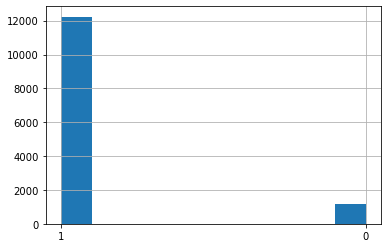

In [113]:
df_items.prop_available.hist()

In [124]:
df_items.prop_categoryid=='1236'

0        False
1        False
2        False
3         True
4        False
         ...  
22452    False
22453    False
22454    False
22455    False
22456    False
Name: prop_categoryid, Length: 22457, dtype: bool

In [119]:
df['categoryid'].fillna(-1, inplace=True)
df['available'].fillna(0, inplace=True)
#df['price'].fillna(0, inplace=True)

In [120]:
dict_price = df.groupby('itemid').price.agg(['mean']).to_dict()
dict_price = dict_price['mean']
df['price'] = df.apply(
    lambda row: dict_price[row['itemid']] if np.isnan(row['price']) else row['price'],
    axis=1
)

In [121]:
display_data(df)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
available,float64,157482,0.0,2
categoryid,float64,157482,0.0,558
date,object,157482,0.0,139
dow,int8,157482,0.0,7
doy,int32,157482,0.0,139
event,object,157482,0.0,3
eventid,int8,157482,0.0,3
hour,int8,157482,0.0,24
itemid,int32,157482,0.0,11926
month,int8,157482,0.0,5


In [122]:
df

,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,eventid,transactionq,price,summa,available,categoryid
0,158090,addtocart,10572,-1,2015-06-02,4,6,153,23,1,1,0,9180.0,0.0,1.0,-1.0
1,1076270,view,262799,-1,2015-06-02,5,6,153,23,1,0,0,72480.0,0.0,1.0,-1.0
2,361387,view,43485,-1,2015-06-02,5,6,153,23,1,0,0,NaN,0.0,0.0,-1.0
3,712443,view,346655,-1,2015-06-02,5,6,153,23,1,0,0,48960.0,0.0,1.0,-1.0
4,599528,addtocart,356475,-1,2015-06-02,5,6,153,23,1,1,0,459840.0,0.0,1.0,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157477,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0
157478,1016212,view,162038,-1,2015-08-01,3,8,213,31,5,0,0,NaN,0.0,1.0,-1.0
157479,175890,view,396732,-1,2015-08-01,4,8,213,31,5,0,0,102240.0,0.0,0.0,-1.0
157480,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0


In [123]:
df[df.price.isna()]

,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,eventid,transactionq,price,summa,available,categoryid
2,361387,view,43485,-1,2015-06-02,5,6,153,23,1,0,0,NaN,0.0,0.0,-1.0
16,85734,view,264801,-1,2015-06-01,21,6,152,23,0,0,0,NaN,0.0,0.0,1613.0
30,273406,view,351798,-1,2015-06-01,16,6,152,23,0,0,0,NaN,0.0,0.0,-1.0
61,286616,view,189444,-1,2015-06-01,18,6,152,23,0,0,0,NaN,0.0,1.0,-1.0
68,518659,view,69427,-1,2015-06-01,18,6,152,23,0,0,0,NaN,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157371,1097216,view,328476,-1,2015-07-31,18,7,212,31,4,0,0,NaN,0.0,0.0,-1.0
157380,896066,view,152627,-1,2015-07-31,17,7,212,31,4,0,0,NaN,0.0,0.0,-1.0
157419,861299,view,367032,-1,2015-07-31,18,7,212,31,4,0,0,NaN,0.0,0.0,-1.0
157435,861299,view,30308,-1,2015-07-31,23,7,212,31,4,0,0,NaN,0.0,0.0,-1.0


In [124]:
# Свойство888
new_df = create_df_feature('888', 'str') #available

df = pd.merge(df, new_df, on=['itemid', 'weekofyear'], how='left')
df.rename(columns = {'value': 'prop888'},  inplace=True)


In [125]:
display_data(df)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
available,float64,157482,0.00,2
categoryid,float64,157482,0.00,558
date,object,157482,0.00,139
dow,int8,157482,0.00,7
doy,int32,157482,0.00,139
event,object,157482,0.00,3
eventid,int8,157482,0.00,3
hour,int8,157482,0.00,24
itemid,int32,157482,0.00,11926
month,int8,157482,0.00,5


In [126]:
# Кластеризация 888
df['prop888'].fillna('9', inplace=True)

dict_clasters['9'] = 9
df['prop888'] = df['prop888'].apply(lambda x: dict_clasters[x])
df['prop888'] = df['prop888'].astype('int16')

In [127]:
df

,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,eventid,transactionq,price,summa,available,categoryid,prop888
0,158090,addtocart,10572,-1,2015-06-02,4,6,153,23,1,1,0,9180.0,0.0,1.0,-1.0,6
1,1076270,view,262799,-1,2015-06-02,5,6,153,23,1,0,0,72480.0,0.0,1.0,-1.0,9
2,361387,view,43485,-1,2015-06-02,5,6,153,23,1,0,0,NaN,0.0,0.0,-1.0,9
3,712443,view,346655,-1,2015-06-02,5,6,153,23,1,0,0,48960.0,0.0,1.0,-1.0,3
4,599528,addtocart,356475,-1,2015-06-02,5,6,153,23,1,1,0,459840.0,0.0,1.0,386.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157477,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0,9
157478,1016212,view,162038,-1,2015-08-01,3,8,213,31,5,0,0,NaN,0.0,1.0,-1.0,9
157479,175890,view,396732,-1,2015-08-01,4,8,213,31,5,0,0,102240.0,0.0,0.0,-1.0,5
157480,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0,9


<AxesSubplot:>

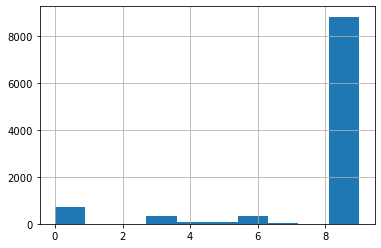

In [128]:
df[df.price.isna()].prop888.hist()

<AxesSubplot:>

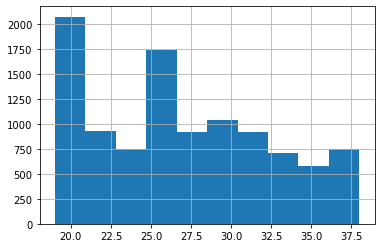

In [129]:
df[df.price.isna()].weekofyear.hist()

<AxesSubplot:>

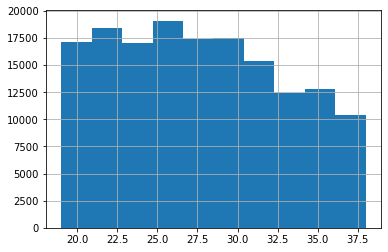

In [130]:
df.weekofyear.hist()

In [131]:
dict_price = df.groupby('visitorid').price.agg(['mean']).to_dict()
dict_price = dict_price['mean']
df['price'] = df.apply(
    lambda row: dict_price[row['visitorid']] if np.isnan(row['price']) else row['price'],
    axis=1
)

<AxesSubplot:>

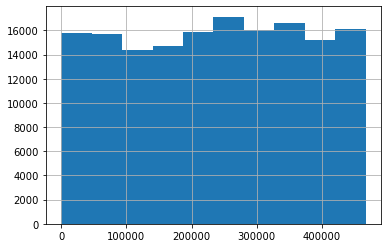

In [132]:
df['itemid'].hist()

<AxesSubplot:>

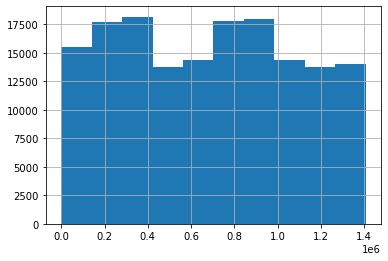

In [133]:
df['visitorid'].hist()

In [134]:
df['visitorid'].nunique(), df['itemid'].nunique()

(11677, 11926)

In [135]:
# Сумма покупки в транзакции нормированная:
dict_check = df.groupby(df['transactionid'])['price'].sum().to_dict()
df['summa'] = df['transactionid'].apply(lambda x: dict_check[x] if x>0 else 0)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157482 entries, 0 to 157481
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   visitorid      157482 non-null  int32  
 1   event          157482 non-null  object 
 2   itemid         157482 non-null  int32  
 3   transactionid  157482 non-null  int32  
 4   date           157482 non-null  object 
 5   hour           157482 non-null  int8   
 6   month          157482 non-null  int8   
 7   doy            157482 non-null  int32  
 8   weekofyear     157482 non-null  int8   
 9   dow            157482 non-null  int8   
 10  eventid        157482 non-null  int8   
 11  transactionq   157482 non-null  int16  
 12  price          155561 non-null  float64
 13  summa          157482 non-null  float64
 14  available      157482 non-null  float64
 15  categoryid     157482 non-null  float64
 16  prop888        157482 non-null  int16  
dtypes: float64(4), int16(2), int3

In [191]:
df

,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,eventid,transactionq,price,summa,available,categoryid,prop888
0,158090,addtocart,10572,-1,2015-06-02,4,6,153,23,1,1,0,9180.0,0.0,1.0,-1.0,6
1,1076270,view,262799,-1,2015-06-02,5,6,153,23,1,0,0,72480.0,0.0,1.0,-1.0,9
2,361387,view,43485,-1,2015-06-02,5,6,153,23,1,0,0,138300.0,0.0,0.0,-1.0,9
3,712443,view,346655,-1,2015-06-02,5,6,153,23,1,0,0,48960.0,0.0,1.0,-1.0,3
4,599528,addtocart,356475,-1,2015-06-02,5,6,153,23,1,1,0,459840.0,0.0,1.0,386.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157477,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0,9
157478,1016212,view,162038,-1,2015-08-01,3,8,213,31,5,0,0,NaN,0.0,1.0,-1.0,9
157479,175890,view,396732,-1,2015-08-01,4,8,213,31,5,0,0,102240.0,0.0,0.0,-1.0,5
157480,118200,view,174923,-1,2015-08-01,3,8,213,31,5,0,0,27960.0,0.0,1.0,-1.0,9


<AxesSubplot:>

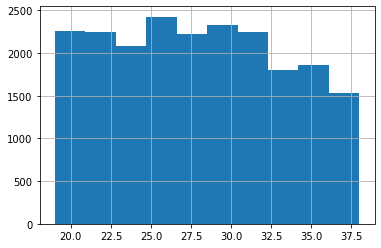

In [181]:
df[df.transactionid>0].weekofyear.hist()

<AxesSubplot:>

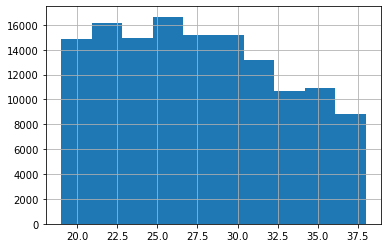

In [180]:
df[df.transactionid<1].weekofyear.hist()

<AxesSubplot:>

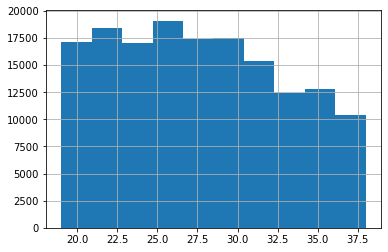

In [179]:
df.weekofyear.hist()

In [230]:
def top_3_sum(x):
    return x.nlargest().count()
def bottom_3_sum(x):
    return x.nsmallest(3).count()
agg_func_top_bottom_sum = {
    'event': [top_3_sum, bottom_3_sum]
}

df[df.event=='transaction'].groupby(['weekofyear', 'itemid']).agg({'event':'count'})

event
weekofyear itemid       
19         829         1
           2657        1
           3629        1
           4001        1
           4215        1
...                  ...
38         463663      1
           464220      1
           464998      1
           465428      1
           466603      1

[17823 rows x 1 columns]

In [252]:
df[(df.event=='transaction')&(df.weekofyear==19)].groupby(['weekofyear', 'itemid'])[['itemid','event']].\
    agg({'event':'count'}).sort_values(by='event', ascending = False)

event
weekofyear itemid       
19         369447     12
           51354       8
           320130      7
           7943        6
           294267      6
...                  ...
           175749      1
           175893      1
           176419      1
           176584      1
           466614      1

[955 rows x 1 columns]

In [262]:
df.weekofyear.max()

38

In [264]:
for i in range(18,df.weekofyear.max()+1):
    print(df[(df.event=='transaction')&(df.weekofyear==i)].groupby(['weekofyear', 'itemid'])[['itemid','event']].\
    agg({'event':'count'}).sort_values(by='event', ascending = False).iloc[:3])

Empty DataFrame
Columns: [event]
Index: []
                   event
weekofyear itemid       
19         369447     12
           51354       8
           320130      7
                   event
weekofyear itemid       
20         369447     11
           379520      9
           7943        4
                   event
weekofyear itemid       
21         369447      7
           358895      6
           314789      5
                   event
weekofyear itemid       
22         448601      9
           85579       7
           318333      7
                   event
weekofyear itemid       
23         7943        6
           318333      6
           420960      5
                   event
weekofyear itemid       
24         370390      5
           361431      5
           305675      5
                   event
weekofyear itemid       
25         222604      5
           416017      5
           216266      4
                   event
weekofyear itemid       
26         382885     13
       

In [256]:
df[(df.event=='transaction')&(df.weekofyear==19)].groupby(['weekofyear', 'itemid'])[['itemid','event']].\
    agg({'event':'count'}).sort_values(by='event', ascending = False).iloc[0].event

12

In [223]:
df[df.event=='transaction'].groupby(['weekofyear', 'itemid']).agg({'event':'count'})

event
weekofyear itemid       
19         829         1
           2657        1
           3629        1
           4001        1
           4215        1
...                  ...
38         463663      1
           464220      1
           464998      1
           465428      1
           466603      1

[17823 rows x 1 columns]

In [224]:
tmp

,weekofyear,itemid,event
0,19,829,1
1,19,2657,1
2,19,3629,1
3,19,4001,1
4,19,4215,1
...,...,...,...
17818,38,463663,1
17819,38,464220,1
17820,38,464998,1
17821,38,465428,1


In [213]:
tmp.groupby(['weekofyear']).agg({'event':'max'})

,event
weekofyear,
19,12
20,11
21,7
22,9
23,6
24,5
25,5
26,13
27,7


In [140]:
df0 = create_rating(df)
df0.fillna(0, inplace=True)
df0.head(3)

,visitorid,itemid,weekofyear,view,addtocart,transaction
0,172,10034,29,4.0,0.0,0.0
1,172,10034,33,1.0,1.0,1.0
2,172,27248,29,1.0,0.0,0.0


In [141]:
df1 = df0.groupby(['itemid','weekofyear'])\
    .agg(view_avg = pd.NamedAgg(column = 'view', aggfunc='sum'),
    addtocart_avg = pd.NamedAgg(column = 'addtocart', aggfunc='sum'),
    transaction_avg = pd.NamedAgg(column = 'transaction', aggfunc='sum'),
    ).reset_index().copy()

In [142]:
goods = df.groupby(['itemid', 'weekofyear'])\
    .agg(quantity_avg = pd.NamedAgg(column = 'transactionq', aggfunc='sum'),
    hour_avg = pd.NamedAgg(column = 'hour', aggfunc='mean'),
    dow_avg = pd.NamedAgg(column = 'dow', aggfunc='mean'),
    prop888_avg = pd.NamedAgg(column = 'prop888', aggfunc='mean'), 
    price_avg = pd.NamedAgg(column = 'price', aggfunc='mean'),      
    summa_avg = pd.NamedAgg(column = 'summa', aggfunc='sum'),      
    ).reset_index().copy()

In [143]:
goods

,itemid,weekofyear,quantity_avg,hour_avg,dow_avg,prop888_avg,price_avg,summa_avg
0,15,28,5,21.142857,3.0,9.0,8400.0,139560.0
1,15,29,0,15.000000,3.0,9.0,8400.0,0.0
2,19,33,4,18.000000,5.0,9.0,18600.0,87740.0
3,25,20,0,16.000000,1.0,0.0,46800.0,0.0
4,25,21,0,19.000000,1.0,0.0,46800.0,0.0
...,...,...,...,...,...,...,...,...
41628,466861,25,0,17.000000,4.0,9.0,348720.0,0.0
41629,466861,26,0,19.000000,2.0,9.0,349125.0,0.0
41630,466861,27,0,18.000000,5.0,9.0,348720.0,0.0
41631,466861,28,1,8.000000,2.0,9.0,348720.0,348720.0


In [144]:
goods = goods.merge(df1, on=['itemid','weekofyear'], how='outer')

In [145]:
interactions = df.groupby(['visitorid', 'itemid', 'weekofyear'])\
    .agg(quantity = pd.NamedAgg(column = 'transactionq', aggfunc='sum'),
    hour = pd.NamedAgg(column = 'hour', aggfunc='mean'),
    dow = pd.NamedAgg(column = 'dow', aggfunc='mean'),
    prop888 = pd.NamedAgg(column = 'prop888', aggfunc='mean'), 
    price = pd.NamedAgg(column = 'price', aggfunc='mean'),      
    summa = pd.NamedAgg(column = 'summa', aggfunc='sum'),      
    ).reset_index().copy()

In [146]:
interactions

,visitorid,itemid,weekofyear,quantity,hour,dow,prop888,price,summa
0,172,10034,29,0,4.000000,1.25,3.0,50520.0,0.0
1,172,10034,33,2,0.333333,5.00,3.0,53520.0,96600.0
2,172,27248,29,0,4.000000,1.00,3.0,53640.0,0.0
3,172,62300,33,0,0.000000,5.00,1.0,26280.0,0.0
4,172,79918,33,0,1.000000,5.00,0.0,46440.0,0.0
...,...,...,...,...,...,...,...,...,...
69925,1407070,80754,20,0,23.000000,2.00,0.0,1439880.0,0.0
69926,1407070,183756,20,0,18.000000,3.00,0.0,2398800.0,0.0
69927,1407070,215596,20,1,22.000000,2.00,0.0,71880.0,71880.0
69928,1407110,360922,32,1,22.500000,1.00,9.0,20400.0,20400.0


In [147]:
interactions = interactions.merge(df0, on=['visitorid', 'itemid','weekofyear'], how='outer')

In [148]:
# not taking book_id into the profiler report
#profile = pandas_profiling.ProfileReport(interactions)
#profile.to_file(r'f:\tmp\profiler_interactions.html')

In [149]:
# not taking book_id into the profiler report
#profile = pandas_profiling.ProfileReport(goods)
#profile.to_file(r'f:\tmp\profiler_goods.html')

In [150]:
# Разбиение на тренировочные и тестовый датасеты по кросс-валидации
# для временных рядов. В нашем случае по номеру недели в году:
# 9 сплитов: 10 недель на трейн, одна - на тест
# далее сдвиг на 1 неделю и так до конца данных
for i in range(19, 28):
    print(i, 9+i, 10+i)

19 28 29
20 29 30
21 30 31
22 31 32
23 32 33
24 33 34
25 34 35
26 35 36
27 36 37


In [151]:
i = 19
_start = i
_end = 9+i
#train, test = split_data(df, _start, _end)

In [152]:
goods

,itemid,weekofyear,quantity_avg,hour_avg,dow_avg,prop888_avg,price_avg,summa_avg,view_avg,addtocart_avg,transaction_avg
0,15,28,5,21.142857,3.0,9.0,8400.0,139560.0,4.0,2.0,1.0
1,15,29,0,15.000000,3.0,9.0,8400.0,0.0,1.0,0.0,0.0
2,19,33,4,18.000000,5.0,9.0,18600.0,87740.0,0.0,1.0,1.0
3,25,20,0,16.000000,1.0,0.0,46800.0,0.0,1.0,0.0,0.0
4,25,21,0,19.000000,1.0,0.0,46800.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
41628,466861,25,0,17.000000,4.0,9.0,348720.0,0.0,1.0,0.0,0.0
41629,466861,26,0,19.000000,2.0,9.0,349125.0,0.0,1.0,0.0,0.0
41630,466861,27,0,18.000000,5.0,9.0,348720.0,0.0,1.0,0.0,0.0
41631,466861,28,1,8.000000,2.0,9.0,348720.0,348720.0,3.0,1.0,1.0


In [153]:
goods = goods[goods.transaction_avg>0]

In [154]:
goods.describe()

,itemid,weekofyear,quantity_avg,hour_avg,dow_avg,prop888_avg,price_avg,summa_avg,view_avg,addtocart_avg,transaction_avg
count,17823.000000,17823.000000,17823.000000,17823.000000,17823.000000,17823.000000,1.770500e+04,1.782300e+04,17823.000000,17823.000000,17823.000000
mean,234993.231891,27.976659,2.407507,14.441068,2.517967,5.923414,1.067553e+05,2.270482e+05,3.940414,1.174494,1.179038
std,133743.412541,5.562785,4.041900,6.246093,1.670398,3.697264,1.635881e+05,5.165344e+05,4.092294,0.937484,0.627060
min,15.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000
25%,120098.000000,23.000000,1.000000,10.181818,1.000000,3.000000,2.124000e+04,3.323455e+04,2.000000,1.000000,1.000000
50%,235971.000000,28.000000,1.000000,16.400000,2.250000,9.000000,5.096400e+04,8.388000e+04,3.000000,1.000000,1.000000
75%,349599.000000,33.000000,2.000000,19.000000,4.000000,9.000000,1.342800e+05,2.256000e+05,5.000000,1.000000,1.000000
max,466861.000000,38.000000,74.000000,23.000000,6.000000,9.000000,5.519880e+06,1.567948e+07,81.000000,29.000000,20.000000


In [155]:
goods.itemid.nunique()

11614

In [156]:
goods['summa_avg'] = np.where(goods.summa_avg==0, goods['price_avg']*goods['transaction_avg'], goods['summa_avg'])
goods = goods[goods.summa_avg!=0]

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
goods.transaction_avg.value_counts()

1.0     15583
2.0      1699
3.0       354
4.0       102
5.0        35
6.0        15
7.0        10
9.0         5
12.0        4
8.0         3
11.0        2
13.0        2
10.0        2
20.0        1
18.0        1
Name: transaction_avg, dtype: int64

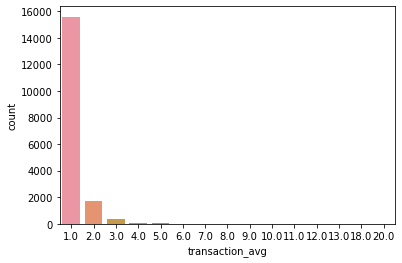

In [158]:
sns.countplot(data=goods, x='transaction_avg')
plt.show()

In [159]:
goods.transaction_avg = np.where(goods.transaction_avg>5,5,goods.transaction_avg)

In [160]:
goods.transaction_avg.value_counts()

1.0    15583
2.0     1699
3.0      354
4.0      102
5.0       80
Name: transaction_avg, dtype: int64

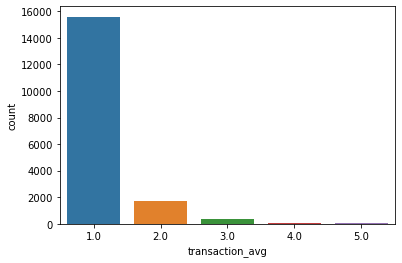

In [161]:
sns.countplot(data=goods, x='transaction_avg')
plt.show()

In [162]:
interactions.describe()

,visitorid,itemid,weekofyear,quantity,hour,dow,prop888,price,summa,view,addtocart,transaction
count,6.993000e+04,69930.000000,69930.000000,69930.000000,69930.000000,69930.000000,69930.000000,6.933600e+04,6.993000e+04,69930.000000,69930.000000,69930.000000
mean,6.771644e+05,236632.552510,27.654769,0.613599,14.701760,2.546009,5.942428,1.094207e+05,5.786758e+04,1.617603,0.333891,0.300501
std,3.939734e+05,133912.967801,5.497416,2.196851,7.141633,1.835869,3.715128,1.647433e+05,2.656451e+05,1.646068,0.604896,0.490340
min,1.720000e+02,15.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3.274370e+05,121595.000000,23.000000,0.000000,11.285714,1.000000,3.000000,2.100000e+04,0.000000e+00,1.000000,0.000000,0.000000
50%,6.876885e+05,239608.000000,27.000000,0.000000,17.000000,2.000000,9.000000,5.396400e+04,0.000000e+00,1.000000,0.000000,0.000000
75%,9.948200e+05,350764.000000,32.000000,1.000000,20.000000,4.000000,9.000000,1.447200e+05,1.884000e+04,2.000000,1.000000,1.000000
max,1.407398e+06,466861.000000,38.000000,60.000000,23.000000,6.000000,9.000000,5.519880e+06,1.325672e+07,79.000000,29.000000,5.000000


In [163]:
interactions = interactions[interactions.transaction>0]

In [164]:
interactions.itemid.nunique(), interactions.visitorid.nunique()

(11614, 11631)

In [165]:
interactions = interactions.dropna()
interactions = interactions[interactions.summa!=0]

In [166]:
#diff = interactions.summa.max()-interactions.summa.min() 
#interactions['rating'] = ((interactions['summa']/diff)*100).round(1)
#interactions.describe()

In [167]:
# Покупки повторные настолько редки, что вряд ли стоит расчитывать на повторение
interactions.transaction.value_counts()

1.0    18872
2.0      675
3.0       87
4.0       12
5.0        3
Name: transaction, dtype: int64

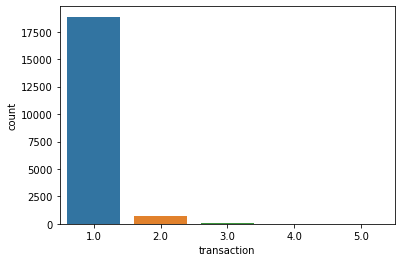

In [168]:
sns.countplot(data=interactions, x='transaction')
plt.show()

In [171]:
interactions['rating'] = interactions['transaction'] 

In [172]:
interactions[interactions['rating']==0]

,visitorid,itemid,weekofyear,quantity,hour,dow,prop888,price,summa,view,addtocart,transaction,rating


In [ ]:
#interactions['rating2'] = pd.qcut(interactions['rating'], 25)

In [176]:
interactions.describe()

,visitorid,itemid,weekofyear,quantity,hour,dow,prop888,price,summa,view,addtocart,transaction,rating
count,1.964900e+04,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,1.964900e+04,1.964900e+04,19649.000000,19649.000000,19649.000000,19649.000000
mean,6.979563e+05,235847.045855,27.993944,2.141483,14.074615,2.495262,5.858415,1.059174e+05,2.059484e+05,2.115782,0.996336,1.045651,1.045651
std,4.015622e+05,134323.481166,5.536874,3.695000,7.162317,1.817050,3.704557,1.614224e+05,4.697413e+05,2.345182,0.653999,0.240670,0.240670
min,1.720000e+02,15.000000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.080000e+03,0.000000,0.000000,1.000000,1.000000
25%,3.476970e+05,121681.000000,23.000000,1.000000,7.000000,1.000000,3.000000,2.040000e+04,3.336000e+04,1.000000,1.000000,1.000000,1.000000
50%,7.118100e+05,237422.000000,28.000000,1.000000,17.000000,2.000000,9.000000,4.860000e+04,7.968000e+04,1.000000,1.000000,1.000000,1.000000
75%,1.035814e+06,350960.000000,32.000000,2.000000,19.600000,4.000000,9.000000,1.384800e+05,2.052000e+05,3.000000,1.000000,1.000000,1.000000
max,1.407398e+06,466861.000000,38.000000,60.000000,23.000000,6.000000,9.000000,5.519880e+06,1.325672e+07,79.000000,29.000000,5.000000,5.000000


<AxesSubplot:>

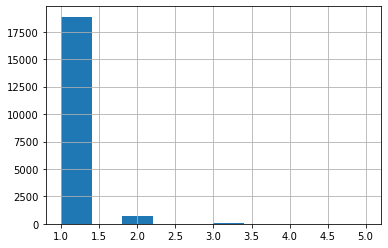

In [177]:
interactions.rating.hist()

In [178]:
interactions_selected = interactions[['visitorid', 'itemid', 'rating']]
interactions_selected.sample(10)

,visitorid,itemid,rating
17259,317906,147509,1.0
11545,220404,158498,1.0
47427,895999,277247,1.0
54885,1042749,448601,1.0
43789,854227,372442,1.0
241,9155,431290,1.0
729,25156,415331,1.0
46400,892355,302242,1.0
2797,64931,409425,1.0
24443,468499,355312,1.0


In [265]:
interactions_selected.shape

(19649, 3)

In [266]:
goods

,itemid,weekofyear,quantity_avg,hour_avg,dow_avg,prop888_avg,price_avg,summa_avg,view_avg,addtocart_avg,transaction_avg
0,15,28,5,21.142857,3.000000,9.0,8400.0,139560.0,4.0,2.0,1.0
2,19,33,4,18.000000,5.000000,9.0,18600.0,87740.0,0.0,1.0,1.0
5,25,24,3,3.250000,0.000000,0.0,37320.0,68640.0,2.0,1.0,1.0
9,25,32,1,0.000000,1.000000,5.0,39000.0,39000.0,0.0,1.0,1.0
12,42,33,2,1.571429,3.000000,0.0,199080.0,275160.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
41620,466603,38,3,6.500000,1.750000,9.0,507240.0,1388640.0,2.0,1.0,1.0
41621,466614,19,1,18.000000,1.000000,9.0,104160.0,104160.0,3.0,1.0,1.0
41622,466614,26,1,20.000000,6.000000,9.0,104160.0,104160.0,6.0,1.0,1.0
41625,466710,30,2,6.333333,2.166667,9.0,5880.0,134160.0,4.0,1.0,1.0


In [267]:
item_dict ={}
_df = goods[['itemid']].sort_values('itemid').reset_index()

for i in range(_df.shape[0]):
    item_dict[(_df.loc[i,'itemid'])] = _df.loc[i,'itemid'].astype('str')

In [268]:
from scipy.sparse import csr_matrix
# convert to csr matrix
goods_csr = csr_matrix(goods.drop('itemid', axis=1).values)
goods_csr

<17818x10 sparse matrix of type '<class 'numpy.float64'>'
	with 169571 stored elements in Compressed Sparse Row format>

In [269]:
goods_interaction = pd.pivot_table(interactions_selected, index='visitorid', columns='itemid', values='rating')

# fill missing values with 0
goods_interaction = goods_interaction.fillna(0)

goods_interaction.head(10)

itemid,15,19,25,42,147,199,212,233,320,403,...,466319,466321,466342,466443,466464,466526,466603,466614,466710,466861
visitorid,,,,,,,,,,,,,,,,,,,,,
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
user_id = list(goods_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [271]:
# convert to csr matrix
goods_interaction_csr = csr_matrix(goods_interaction.values)
goods_interaction_csr

<11228x11267 sparse matrix of type '<class 'numpy.float64'>'
	with 19505 stored elements in Compressed Sparse Row format>

In [272]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM

model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(goods_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [273]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, threshold = 0,nrec_items = 3, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    print('n_users, n_items=', n_users, n_items)
    print('user_x=', user_x)
    print(goods_interaction_csr.shape)
    print(goods_interaction_csr.shape[0])
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=goods_interaction_csr.T))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1

In [274]:
model.get_params()

{'loss': 'warp',
 'learning_schedule': 'adagrad',
 'no_components': 150,
 'learning_rate': 0.9,
 'k': 5,
 'n': 10,
 'rho': 0.95,
 'epsilon': 1e-06,
 'max_sampled': 10,
 'item_alpha': 0.0,
 'user_alpha': 5e-06,
 'random_state': RandomState(MT19937) at 0x20AA9568268}

In [275]:
model.get_item_representations()[0].shape, model.get_item_representations()[1].shape

((11267,), (11267, 150))

In [276]:
model.get_user_representations()[0].shape, model.get_user_representations()[1].shape

((11228,), (11228, 150))

In [277]:
model.k

5

In [278]:
sample_recommendation_user(model, goods_interaction, 1407070, user_dict, item_dict)

n_users, n_items= 11228 11267
user_x= 11225
(11228, 11267)
11228
User: 1407070
Known Likes:
1- 215596

 Recommended Items:
1- 389814
2- 63750
3- 233695


In [279]:
train_precision = precision_at_k(model, goods_interaction, k=3).mean()
#test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, goods_interaction).mean()
#test_auc = auc_score(model, test).mean()

#print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
#print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
print('Precision: train %.2f' % (train_precision))
print('AUC: train %.2f' % (train_auc))

AttributeError: 'DataFrame' object has no attribute 'tocsr'

In [ ]:
lightfm.evaluation.precision_at_k(
lightfm.evaluation.auc_score
    
    

In [ ]:
goods.groupby('weekofyear').itemid.agg(['count'])

In [ ]:
goods

In [ ]:
df[df.visitorid==1407070]

In [ ]:
df[df.transactionq>2].weekofyear.hist()

In [ ]:
df[df.transactionq>2].weekofyear.value_counts()

In [ ]:
df0 = df[df['event']=='transaction'][['itemid', 'visitorid','available', 'dow', 'doy','categoryid',\
                'hour','month','price','prop888','summa', 'transactionq', 'weekofyear']].copy()

In [ ]:
display_data(df0)

In [ ]:
df0.info()

In [ ]:
df0.groupby(['visitorid', 'itemid', 'weekofyear']).itemid.agg(['count']).value_counts()

In [ ]:
df0.groupby(['visitorid', 'itemid', 'weekofyear']).itemid.agg(['count'])
#dict_rating = dict_rating['count']

In [ ]:
 df0 = df0.merge(df0.groupby(['visitorid','itemid', 'weekofyear'])\
        .agg(rating = pd.NamedAgg(column = 'itemid', aggfunc='count'),
        ), left_on=['visitorid','itemid', 'weekofyear'],\
        right_on=['visitorid','itemid', 'weekofyear'],\
        how='outer')

In [ ]:
df0.rating.value_counts()

In [ ]:
df0.rating.hist()

In [ ]:
df0.prop888.hist(bins=20)

In [ ]:
df0.corr()

In [ ]:
# рисуем тепловую карту необработанных значений
num_columns = [x for x in df0.columns if not df0[x].dtypes == 'object']
show_correlation(df0, num_columns)

**Data Preprocessing**

In [ ]:
df0 = df[df['event']=='transaction'][['itemid', 'visitorid','available', 'dow', 'doy','categoryid',\
                'hour','month','price','prop888','summa', 'transactionq', 'weekofyear']].copy()

In [ ]:
display_data(df0)

Выбрали только 22457 записей чисто с продажами

In [ ]:
import pandas_profiling

In [ ]:
profile = pandas_profiling.ProfileReport(df0)
profile.to_file(r'f:\tmp\profiler_df0.html')

In [ ]:
df0['available'] = np.where(df0['available']==2, 0, df0['available'])

In [ ]:
df0['categoryid'] = pd.cut(df0['categoryid'], bins=25)

In [ ]:
profile = pandas_profiling.ProfileReport(df0)
profile.to_file(r'f:\tmp\profiler_df0.html')

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
item_dict ={}
df_ = df0[['itemid', 'categoryid']].sort_values('itemid').reset_index()
for i in range(df_.shape[0]):
    item_dict[(df_.loc[i,'itemid'])] = df_.loc[i,'categoryid']
# dummify categorical features
df_transformed = pd.get_dummies(df0, columns = ['rating', 'price', 'transactionq','month', 'hour', 'prop888', 'dow'])
df_transformed = df_transformed.sort_values('itemid').reset_index().drop('index', axis=1)
df_transformed.head(5)
# convert to csr matrix
metadata_csr = csr_matrix(df_transformed.drop('itemid', axis=1).values)

In [ ]:
df_transformed.head(5)

In [ ]:
#Сформируем датафрейм с покупаемыми товарами

ind = events[events.event=='transaction'].itemid.tolist() # список покупаемых товаров
df = events.loc[events.itemid.isin(ind)].copy()
df.head(10)

In [ ]:
prepare_events(df)

# Создание датасета

In [ ]:
dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}
df = create_dataframe(df, dict_actions)

In [ ]:
df.info()

**Мы видим, что при соединении датафреймов по полю времени weekofyear в итоговую таблицу попадает лишь 21499 записей из 22457 в первую неделю. Попробуем проследить дальнейшую динамику оплат просмотренных товаров и найдем 90% доверительный интервал истинной доли оплат, приходящихся на первую неделю. Возможно, что остальными расчетами можно пренебречь**

In [ ]:
644068-622569

In [ ]:
p = round(21499/22457,3)
p

In [ ]:
q = round(1 - p, 3)
q

In [ ]:
# Критическое значение alfa = 1 - 0.90 = 0.1
# alfa_2 = alfa/2 = 0.05
# По таблицам статистики Z_alfa_2 = 1.645
# p - 1.645 * np.sqrt(p*(1-p)/n) < p < p + 1.645 * np.sqrt(p*(1-p)/n)

In [ ]:
n = 22457
x1 = round(p - 1.645 * np.sqrt(p*(1-p)/n),3)
x2 = round(p + 1.645 * np.sqrt(p*(1-p)/n),3)
print(x1, x2)

**Мы на 90% уверены, что от 95 до 96% товаров, которые будут куплены проплачиваются в первую неделю**

In [ ]:
df['weekofyear'].nunique() # 21 неделя данных

Проследим динамику продаж товаров, к которым был проявлен интерес в 1-ую неделю с течением времени:

In [ ]:
df1 = df[df.transaction.isna()][['visitorid', 'itemid', 'weekofyear'\
    , 'view', 'hour_view', 'dow_view', 'month_view', 'doy_view'\
    , 'addtocart', 'hour_addtocart', 'dow_addtocart', 'month_addtocart', 'doy_addtocart']].copy()
df2 = df[df.view.isna()][['visitorid', 'itemid', 'weekofyear'\
    , 'transaction', 'hour_transaction', 'dow_transaction', 'month_transaction', 'doy_transaction']].copy()
df2['weekofyear'] = df2['weekofyear']- 1

In [ ]:
df0 = df1.merge(df2, left_on=['visitorid','itemid', 'weekofyear']\
        , right_on=['visitorid','itemid', 'weekofyear'], how='left')

In [ ]:
print('Через {} неделю было {} продаж'\
        .format(1,df0['transaction'].notna().sum()))

In [ ]:
for i in range(2, 21):
    
    df2['weekofyear'] = df2['weekofyear']- 1
    df0 = df1.merge(df2, left_on=['visitorid','itemid', 'weekofyear']\
        , right_on=['visitorid','itemid', 'weekofyear'], how='left')
    print('Через {} недели было {} продаж'\
        .format(i,df0['transaction'].notna().sum()))


In [ ]:
df[df['transaction'].notna()].info()

In [ ]:
df = df[df['transaction'].notna()].copy()

In [ ]:
df['visitorid'].value_counts()

In [ ]:
df['itemid'].value_counts()

In [ ]:
# Заполняем пустые значения:
# Если товар был продан, то он был предварительно уложен в корзину
# Если товар положен в корзину, то он был предварительно просмотрен
# Остальное - нули
df['addtocart'].fillna(df['transaction'], inplace=True)
df['view'].fillna(df['addtocart'], inplace=True)
df['hour_addtocart'].fillna(df['hour_transaction'], inplace=True)
df['hour_view'].fillna(df['hour_addtocart'], inplace=True)
'''
df['addtocart'].fillna(0, inplace=True)
df['transaction'].fillna(0, inplace=True)

df['hour_transaction'].fillna(-1, inplace=True)
df['hour_addtocart'].fillna(-1, inplace=True)
df['hour_transaction'].fillna(-1, inplace=True)
'''


In [ ]:
df.info()

In [ ]:
df.head(5)

In [ ]:
# Заполняем пустые значения:
# Если товар был продан, то он был предварительно уложен в корзину
# Если товар положен в корзину, то он был предварительно просмотрен
# Остальное - нули
df['addtocart'].fillna(df['transaction'], inplace=True)
df['view'].fillna(df['addtocart'], inplace=True)
df['hour_view'].fillna(df['hour_transaction'], inplace=True)
df['addtocart'].fillna(0, inplace=True)
df['transaction'].fillna(0, inplace=True)

In [ ]:
df

In [ ]:
print(df.view.value_counts()[:10])
df.view.value_counts()[:10].plot(kind='barh')

In [ ]:
print(df.addtocart.value_counts())
df.addtocart.value_counts()[:].plot(kind='barh')

In [ ]:
print(df.transaction.value_counts())
df.transaction.value_counts().plot(kind='barh')

**Для валидации будем использовать разбиение по временным интервалам: например, по неделям (weekofyear). Это возможно в силу того, что у нас данные только 2015 года.**

In [ ]:
# Записываем датафрейм в файл с рейтингами
df[['doy','visitorid','itemid','rating']].to_csv(os.path.join(path,'ratings.csv'))

In [ ]:
for col in dict_actions.values():
    #print(col)
    df[col] = df[col].astype('int16')

In [ ]:
df.describe()

In [ ]:
df[['addtocart', 'transaction']].hist(bins=50);

In [ ]:
from scipy.stats import shapiro
def test_shapiro(sample, alpha, text):
    '''
    Тест Шапиро-Уилка
    sample - выборка
    alpha - 
    '''
    stat, p = shapiro(sample)
    print('Статистика=%.3f, p=%.3f' % (stat, p))
    # interpret
    
    if p > alpha:
        print(f'Выборка {text} выглядит гауссовой (не удается отклонить H0)')
    else:
        print(f'Выборка {text} не выглядит Гауссовой (отклонить H0)')

In [ ]:
test_shapiro(df['addtocart'], 0.05, 'addtocart')

In [ ]:
test_shapiro(df['transaction'], 0.05, 'transaction')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def _kde(feature):
    '''
    Сравнение признаков по группам
    '''
    for feat in feature:
        sns.kdeplot(x=feat, data=df, common_norm=False, label=feat);
    
    plt.legend(title='features', loc='upper right')    
    plt.title("Kernel Density Function");

In [ ]:
_kde(['view'])

In [ ]:
_kde(['addtocart'])

In [ ]:
_kde(['transaction'])

In [ ]:
# Перекодируем категориальный признак event:
ord_enc = OrdinalEncoder()
events["eventid"] = ord_enc.fit_transform(events[["event"]])

In [ ]:
events["eventid"].value_counts()

In [ ]:
events["eventid"] = events["eventid"].astype('int8')
events = events.drop(columns='event')

In [ ]:
events.info()

In [ ]:
events['itemid'].value_counts()[:2]

In [ ]:
events.iloc[events['itemid'].value_counts()[:2].index.tolist()]['itemid'].value_counts().hist(bins=100)

## Исследование данных

<a id='1'></a> 
### Описание структуры
<a href='#0'> *Вернуться к оглавлению*

<a id='6'></a> 
### Статистический анализ данных
<a href='#0'> *Вернуться к оглавлению*

In [ ]:
display_data(df)

In [ ]:
df.transactionid.unique()

In [ ]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df['weekofyear'], order=df['weekofyear'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df[df['transactionid']>0]['dow'], order=df[df['transactionid']>0]['dow'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df[df['transactionid']>1]['doy'], order=df[df['transactionid']>1]['doy'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

In [ ]:
get_boxplot(df[df['transactionid']>1], 'dow', 'summa')

In [ ]:
# рисуем тепловую карту необработанных значений
num_columns = [x for x in df.columns if not df[x].dtypes == 'object']
show_correlation(df, num_columns)

In [ ]:
drop_collinear_features = ['month','doy','summa'] # 'number_of_reviews','indicator','price_range','quantity_rest','date_from_max']
                           
num_columns = list(set(num_columns)-set(drop_collinear_features))
show_correlation(df, num_columns)

In [ ]:
most_correlated = df.corr().abs()['transactionq'].sort_values(ascending=False)
most_correlated

# LightFM

In [ ]:
from lightfm import LightFM
import scipy

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df = df[['doy', 'rating', 'itemid', 'visitorid']].copy()
df['doy'] = df['doy'].astype('int16')
df['rating'] = df['rating'].astype('int16')
df['itemid'] = df['itemid'].astype('int32')
df['visitorid'] = df['visitorid'].astype('int32')

arr_range = df['doy'].unique().tolist()
#for i in range(arr_range[0], arr_range[-1],9):
#  print(i, i+9-1)
df.sort_values('doy', inplace=True)

df['score'] = (df['rating'] > 20).apply('int16')
df.info()

In [ ]:
df.doy.unique()

In [ ]:
arr_range = df['doy'].unique().tolist()
for i in range(arr_range[0], arr_range[-1],9):
  print(i, i+9-1)

In [ ]:
arr_range = df['doy'].unique().tolist()
for i in range(0,len(arr_range),9):
    print(i)
    start = arr_range[i]
    if (i+8) < len(arr_range)-1:
        end = arr_range[i+8]
    else:
        end = arr_range[-1]

    ratings = df[(df.doy>=start)&(df.doy<=end)]
    train = ratings[(ratings.doy>=start)&(ratings.doy<end)]
    test = ratings[ratings.doy==end]

    train_pivot = pd.pivot_table(
        train,
        index="visitorid", 
        columns="itemid", 
        values="score"
        )
    test_pivot = pd.pivot_table(
        test,
        index="visitorid", 
        columns="itemid", 
        values="score"
        )

    print(train_pivot.shape)
    print(test_pivot.shape)
    ## (751, 1616)
    ## (301, 1448)

    shell = pd.pivot_table(
        ratings, 
        index="visitorid", 
        columns="itemid", 
        values="score", 
        aggfunc=lambda x: 0
        )

    train_pivot = shell + train_pivot
    test_pivot = shell + test_pivot

    train_pivot = (train_pivot + 1).fillna(0)
    test_pivot = (test_pivot + 1).fillna(0)
    print(train_pivot.shape)
    print(test_pivot.shape)
    ## (943, 1682)
    ## (943, 1682)


    train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
    test_pivot_sparse = scipy.sparse.csr_matrix(test_pivot.values)

    model = AlternatingLeastSquares(factors=3, random_state=42)
    model.fit(train_pivot_sparse)

    unique_items = np.array(train_pivot.columns)
    user_id = 14
    recomendations_ids, scores = model.recommend(user_id, train_pivot_sparse[user_id])
    recomendations = unique_items[recomendations_ids]
    print('Recomendations ids: {}'.format(recomendations_ids))
    print('Recomendations for user {}: {}'.format(user_id, recomendations))

    ## Recomendations ids: [293 116  99 275 244 287 283 150 125 596]
    ## Recomendations for user 14: [294 117 100 276 245 288 284 151 126 597]

    map_at10 = mean_average_precision_at_k(model, train_pivot_sparse, test_pivot_sparse, K=3)
    print('Mean Average Precision at 10: {:.10f}'.format(map_at10))

    ## Mean Average Precision at 10: 0.087


In [ ]:
# Смотрим по рейтингу, что покупалось более 1 раза: покупка оценивается 10 баллов,
# значит yfc bynthtcetn htqnbyu >20
df[df.rating>20].rating.hist(bins=50)

In [ ]:
df.info()

In [ ]:
train

In [ ]:
df.drop(['score'], axis=1, inplace=True)

In [ ]:
train = df[df.doy<260].copy()
test = df[df.doy==260]
# Лисицкая

In [ ]:
df0 = train[['itemid', 'visitorid', 'rating']].copy()
#df0.drop(['doy','score'], axis=1,inplace=True)

In [ ]:
df0

In [ ]:
train_pivot = pd.pivot_table(
    train[['itemid', 'visitorid', 'rating']],
    index="visitorid", 
    columns="itemid", 
    values="rating"
    )
test_pivot = pd.pivot_table(
    test[['itemid', 'visitorid', 'rating']],
    index="visitorid", 
    columns="itemid", 
    values="rating"
    )

print(train_pivot.shape)
print(test_pivot.shape)

In [ ]:
df1 = df0.groupby(['visitorid','itemid'])[['rating']].sum()
df1.reset_index(inplace=True)
df1

In [ ]:
# для этого воспользуемся функцией pivot и создадим сводную таблицу (pivot table)
# по горизонтали будут продукты по вертикали - пользователи, значения - оценки
user_item_matrix = df1.pivot(index = 'itemid', columns = 'visitorid', values= 'rating')
user_item_matrix.head()

In [ ]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating 
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = df0.groupby('visitorid')['rating'].agg('count')

# сделаем то же самое, только для продукта
item_votes = df0.groupby('itemid')['rating'].agg('count')

In [ ]:
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 20].index
item_mask = item_votes[item_votes > 20].index

<a id='10'></a> 
### Коллаборативная фильтрация
<a href='#0'> *Вернуться к оглавлению*

In [ ]:
#Сформируем датафрейм с покупаемыми товарами

ind = events[events.event=='transaction'].itemid.tolist() # список покупаемых товаров
df = events.loc[events.itemid.isin(ind)].copy()
#df.head

**Из полученного датасета выберем 1000 наиболее проаваемых товаров**

In [ ]:
df.info()

In [ ]:
df[df['transactionid']>0]['itemid'].nunique(), df['itemid'].nunique()

In [ ]:
ind_items_1000 = df['itemid'].value_counts()[:1000].index.tolist()

**Аналогично определим покупателей** Будем брать в рассмотрение покупателей, совершивших более 10 покупок. Их только 130

In [ ]:
df[df['transactionid']>0]['visitorid'].nunique(), df['visitorid'].nunique()

In [ ]:
df[df['transactionid']>0]['visitorid'].value_counts()[:100]

In [ ]:
df[df['transactionid']>0]['visitorid'].value_counts().iloc[130]

In [ ]:
ind_visitors_130 = df[df['transactionid']>0]['visitorid'].value_counts()[:130].index.tolist()

**Отфильтруем данные**

In [ ]:
df0 = df.set_index('visitorid').loc[ind_visitors_130].reset_index().copy()

In [ ]:
df0

In [ ]:
df0['itemid'].value_counts()[:1120]

In [ ]:
ind_items_1000 = df0['itemid'].value_counts()[:1120].index.tolist()

In [ ]:
df0 = df0.set_index('itemid').loc[ind_items_1000].reset_index().copy()

In [ ]:
df0

In [ ]:
df0.itemid.value_counts()

In [ ]:
df0.visitorid.value_counts()

In [ ]:
df0.event.value_counts().plot(kind='barh');
df0.event.value_counts()

In [ ]:
df0.info()

In [ ]:
df0 = prepare_events(df0)

In [ ]:
df0.info()

In [ ]:
df0.eventid.value_counts().plot(kind='barh');
df0.eventid.value_counts()

In [ ]:
df0

In [ ]:
df0['transactionid'].value_counts()

In [ ]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df0['weekofyear'], order=df0['weekofyear'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df0[df0['eventid']==2]['weekofyear'], order=df0['weekofyear'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

In [ ]:
df0['weekofyear'].value_counts()

In [ ]:
sorted(df0['weekofyear'].unique())

**Крайние недели 18 и 38 являются выбросами**

In [ ]:
len(sorted(df0['weekofyear'].unique()))-2

In [ ]:
# Разбиение на тренировочные и тестовый датасеты по кросс-валидации
# для временных рядов. В нашем случае по номеру недели в году:
# 9 сплитов: 10 недель на трейн, одна - на тест
# далее сдвиг на 1 неделю и так до конца данных
for i in range(19, 28):
    print(i, 9+i, 10+i)

In [ ]:
def split_data(df, _start, _end):
    '''
    Разделение для кроссвалидации
    '''
    train = df[df['weekofyear'].between(_start,_end)].\
        groupby(['visitorid','itemid'])['rating'].agg('mean').round().\
        to_frame().reset_index().copy()
    test = df[df['weekofyear']==_end][['visitorid','itemid', 'rating']].copy()
    
    return train, test

In [ ]:
df0[(df0['weekofyear']==30)&(df0['transactionid']>0)]

In [ ]:
# Расчет рейтинга для каждого покупателя по покупаемым товарам понедeльно
#df0 = df0.groupby(['visitorid','itemid','weekofyear'])['eventid']\
#.agg('sum').to_frame().reset_index().copy()

In [ ]:
# Расчет рейтинга для каждого покупателя по покупаемым товарам понедeльно
df0 = df0.groupby(['visitorid','itemid','weekofyear']).\
    agg(rating = pd.NamedAgg(column = 'eventid', aggfunc='sum'),).reset_index().copy()

In [ ]:
df0

In [ ]:
i = 19
_start = i
_end = 9+i
train, test = split_data(df0, _start, _end)

In [ ]:
train

In [ ]:
test

In [ ]:
for i in range(19,28):
    _start = i
    _end = 9+i

In [ ]:
from surprise import KNNWithMeans, KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise import Reader

In [ ]:
test.rating.value_counts()

In [ ]:
train.rating.value_counts()

In [ ]:
train['rating'] = np.where(train.rating>5, 5, train['rating'])
test['rating'] = np.where(test.rating>5, 5, test['rating'])
train = train.rename(columns = {"visitorid": "uid","itemid": "iid"})
test = test.rename(columns = {"visitorid": "uid","itemid": "iid"})

In [ ]:
train

In [ ]:
reader = Reader(rating_scale=(0, 5.0))
data = Dataset.load_from_df(train[['uid', 'iid', 'rating']], reader)

In [ ]:
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate

In [ ]:
cross_validate(NormalPredictor(), data, cv=2)

In [ ]:
data.df

In [ ]:
data.df.rating.hist()

In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.1)

In [ ]:
algo = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

In [ ]:
trainset.n_users

In [ ]:
test_pred = algo.test(testset)

In [ ]:
accuracy.rmse(test_pred, verbose=True)

In [ ]:
test

In [ ]:
algo.min_k

In [ ]:
test_pred

In [ ]:
algo.sim_options

# LightFM

In [179]:
import numpy as np
from lightfm.datasets import fetch_movielens
data = fetch_movielens(min_rating=5.0)

In [180]:
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 19048 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 2153 stored elements in COOrdinate format>


In [181]:
from lightfm import LightFM

In [182]:
model = LightFM(loss='warp')
%time model.fit(data['train'], epochs=30, num_threads=2)

Wall time: 1.43 s


In [183]:
from lightfm.evaluation import precision_at_k

In [184]:
print("Train precision: %.2f" % precision_at_k(model, data['train'], k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, data['test'], k=5).mean())

Train precision: 0.41
Test precision: 0.06


In [193]:
data['test'].shape

(943, 1682)

In [186]:
def sample_recommendation(model, data, user_ids):
    

    n_users, n_items = data['train'].shape
    print('n_users, n_items=', n_users, n_items)
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)
        
sample_recommendation(model, data, [3, 25, 450]) 


n_users, n_items= 943 1682
User 3
     Known positives:
        Contact (1997)
        Air Force One (1997)
        In & Out (1997)
     Recommended:
        Kiss the Girls (1997)
        Chasing Amy (1997)
        Contact (1997)
User 25
     Known positives:
        Fargo (1996)
        Godfather, The (1972)
        L.A. Confidential (1997)
     Recommended:
        Star Wars (1977)
        Titanic (1997)
        L.A. Confidential (1997)
User 450
     Known positives:
        Event Horizon (1997)
        Scream (1996)
        Conspiracy Theory (1997)
     Recommended:
        Air Force One (1997)
        Game, The (1997)
        Scream (1996)


# https://www.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/

In [2]:
! pip install helpers

In [21]:
import scipy.sparse as sp
import numpy as np


def threshold_interactions_df(df, row_name, col_name, row_min, col_min):
    """Limit interactions df to minimum row and column interactions.

    Parameters
    ----------
    df : DataFrame
        DataFrame which contains a single row for each interaction between
        two entities. Typically, the two entities are a user and an item.
    row_name : str
        Name of column in df which corresponds to the eventual row in the
        interactions matrix.
    col_name : str
        Name of column in df which corresponds to the eventual column in the
        interactions matrix.
    row_min : int
        Minimum number of interactions that the row entity has had with
        distinct column entities.
    col_min : int
        Minimum number of interactions that the column entity has had with
        distinct row entities.
    Returns
    -------
    df : DataFrame
        Thresholded version of the input df. Order of rows is not preserved.

    Examples
    --------

    df looks like:

    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
      1002  |  2002

    thus, row_name = 'user_id', and col_name = 'item_id'

    If we were to set row_min = 2 and col_min = 1, then the returned df would
    look like

    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004

    """

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Starting interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of cols: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))

    done = False
    while not done:
        starting_shape = df.shape[0]
        col_counts = df.groupby(row_name)[col_name].count()
        df = df[~df[row_name].isin(col_counts[col_counts < col_min].index.tolist())]
        row_counts = df.groupby(col_name)[row_name].count()
        df = df[~df[col_name].isin(row_counts[row_counts < row_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Ending interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of columns: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df


def get_df_matrix_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices

    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.

    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix

    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str

    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict

    """

    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_matrix_mappings(df,
                                                        row_name,
                                                        col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = np.array(df[row_name].apply(map_ids, args=[rid_to_idx]))
    J = np.array(df[col_name].apply(map_ids, args=[cid_to_idx]))
    V = np.ones(I.shape[0])
    interactions = sp.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def train_test_split(interactions, split_count, fraction=None):
    """
    Split recommendation data into train and test sets

    Params
    ------
    interactions : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = interactions.copy().tocoo()
    test = sp.lil_matrix(train.shape)

    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],
                replace=False,
                size=np.int64(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])

    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(interactions.getrow(user).indices,
                                        size=split_count,
                                        replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = interactions[user, test_interactions]


    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit
import pickle
import csv
import copy
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys

In [4]:
df = pd.read_csv(r'F:\SkillFactory\diplom\model_likes_anon.psv.txt',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.drop_duplicates(inplace=True)
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632677 entries, 0 to 632826
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   modelname  632677 non-null  object
 1   mid        632677 non-null  object
 2   uid        632677 non-null  object
dtypes: object(3)
memory usage: 19.3+ MB


In [15]:
# Threshold data to only include users and models with min 5 likes.
df = threshold_interactions_df(df, 'uid', 'mid', 5, 5)

Starting interactions info
Number of rows: 62583
Number of cols: 28806
Sparsity: 0.035%
Ending interactions info
Number of rows: 15274
Number of columns: 25655
Sparsity: 0.140%


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547477 entries, 1 to 632821
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   modelname  547477 non-null  object
 1   mid        547477 non-null  object
 2   uid        547477 non-null  object
dtypes: object(3)
memory usage: 16.7+ MB


In [22]:
# Go from dataframe to likes matrix
# Also, build index to ID mappers.
likes, uid_to_idx, idx_to_uid,\
mid_to_idx, idx_to_mid = df_to_matrix(df, 'uid', 'mid')

likes

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 547477 stored elements in Compressed Sparse Row format>

In [24]:
train, test, user_index = train_test_split(likes, 5, fraction=0.2)

In [34]:
train.shape

(15274, 25655)

In [33]:
test.shape

(15274, 25655)

In [30]:
len(user_index)

3054

In [35]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()